# Experimento06: Redes Recurrentes GRU

## Librerías

In [4]:
# Librerias necesarias
import os

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':40,
         'ytick.labelsize': 40
}
plt.rcParams.update(params)
# Seaborn conf
import seaborn as sns
sns.set(style='darkgrid')
sns.set_palette(sns.color_palette("Blues"))

import sys

#Procesado de datos
import pandas as pd
import numpy as np
import operator

#Modelos
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')


from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from nltk import ngrams

from keras.layers import Dense, Embedding, Flatten, GlobalMaxPool1D, Dropout
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers

from keras.initializers import Constant

from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
import tensorflow as tf

from sklearn import preprocessing
from nltk import ngrams

from tensorflow.keras import regularizers

## Carga de conjunto de datos

In [3]:
df_training = pd.read_csv("./data/ds_training_processed.csv")
df_testing = pd.read_csv("./data/ds_testing_processed.csv")

X_train = df_training["text"]
y_train = df_training["sentiment"]
X_test = df_testing["text"]
y_test = df_testing["sentiment"]

y_train_2 = to_categorical(y_train, num_classes=2)
y_test_2 = to_categorical(y_test, num_classes=2)

## Carga de modelos de representación

In [4]:
def load_representation_model(file_name, include_embedding_matrix=False):
    res = {}
    with open("./repmodels/"+file_name+".txt", 'r') as d:
        res["model"] = d.readline()
    res["train_text_features"] = np.load("./repmodels/"+file_name+"_train.npy")
    res["test_text_features"] = np.load("./repmodels/"+file_name+"_test.npy")

    if include_embedding_matrix:
        res["embedding_matrix"] = np.load("./repmodels/"+file_name+"_embeddingmatrix.npy")

    return res

vsm_binary = load_representation_model("vsm_binary")
vsm_binary_ngrams = load_representation_model("vsm_binary_ngrams")
vsm_tfidf = load_representation_model("vsm_tfidf")
vsm_tfidf_ngrams = load_representation_model("vsm_tfidf_ngrams")
embedding_padding = load_representation_model("embedding_padding")
embedding_glove = load_representation_model("embedding_glove", include_embedding_matrix=True)

# Cargo esto por facilidad
vsm_model = []
vsm_model.append(vsm_binary)
vsm_model.append(vsm_binary_ngrams)
vsm_model.append(vsm_tfidf)
vsm_model.append(vsm_tfidf_ngrams)

## Funciones generales

In [6]:
pd.set_option('display.max_colwidth', 2000)
vocab_size = 29773
emb_dim = 50
num_words = 29773

results = []
def add_to_results(classifier, repmodel, predict_x, y_test):
    y_pred = np.argmax(predict_x,axis=1)

    results.append({"classifier": classifier,
                    "rep.model": repmodel,
                    "accuracy": accuracy_score(y_test, y_pred),
                    "precision": precision_score(y_test, y_pred, average="weighted"),
                    "recall": recall_score(y_test,y_pred, average="weighted")
                    })

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'bo', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel("Epochs")
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def nn_classification_report(predict_x, y_test, class_names):
    y_pred = np.argmax(predict_x,axis=1)

    print("Classification Report")
    print

    print(classification_report(y_true=y_test, y_pred=y_pred, target_names=class_names))
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    plot_confusion_matrix(cm, classes=class_names)

    print("Final Accuracy")
    print(accuracy_score(y_test, y_pred))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def join_csv_for_experiment(experiment_string, number_of_experiements):
    experiments_data = []
    for i in range(1, number_of_experiements+1):
        experiments_data.append( pd.read_csv("exp_"+experiment_string+"_"+str(i)+".csv") )

    res = pd.concat(experiments_data, ignore_index=True)
    res.to_csv("exp_"+experiment_string+".csv")

## Clasificadores

In [8]:
def build_exp06(
        name, 
        description, 
        rep, 
        input_shape,
        embedding=None,
        exp="Exp06",
        layers_units=[64],
        extra_dense_layer_nn=0,
        extra_dense_dropout_layer=0.0,
        dropout=[0.0],
        recurrent_dropout=[0.0],
        make_it_bidirectional=False,
        kernel_regularizer=None
        ):
    callbacks = [
        keras.callbacks.EarlyStopping(
                monitor='val_loss',
                mode='min', 
                patience=7, 
                min_delta=0.01)        
    ]    
    inputs = keras.Input(shape=input_shape, dtype="float")

    return_sequences = False
    if len(layers_units)>1:
        return_sequences = True
    
    first_layer = layers.GRU(layers_units[0], 
                             return_sequences=return_sequences, 
                             dropout=dropout[0], 
                             recurrent_dropout=recurrent_dropout[0], 
                             kernel_regularizer=kernel_regularizer)
    if make_it_bidirectional:
        first_layer = layers.Bidirectional(first_layer)

    if embedding:
        x = embedding(inputs)
        x = first_layer(x)
    else:
        x = first_layer(inputs)

    if return_sequences:
        layers_units.pop(0)
        for i, _ in enumerate(layers_units[:-1]):
            new_layer = layers.GRU(layers_units[i], 
                                   return_sequences=True, 
                                   dropout=dropout[i], 
                                   recurrent_dropout=recurrent_dropout[i], 
                                   kernel_regularizer=kernel_regularizer)
            if make_it_bidirectional:
                new_layer = layers.Bidirectional(new_layer)
            x = new_layer(x)
        last_layer = layers.GRU(layers_units[-1], 
                                return_sequences=False, 
                                dropout=dropout[-1], 
                                recurrent_dropout=recurrent_dropout[-1], 
                                kernel_regularizer=kernel_regularizer)
        new_layer = last_layer
        if make_it_bidirectional:
            new_layer = layers.Bidirectional(last_layer)        
        x = new_layer(x)

    if extra_dense_layer_nn > 0:
        x = layers.Dense(extra_dense_layer_nn, activation="relu")(x)
        if extra_dense_dropout_layer > 0:
            x = layers.Dropout(extra_dense_dropout_layer)(x)
    
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model._name = exp+name
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print(model.summary())
    history = model.fit(rep["train_text_features"].astype(float), 
                        y_train_2, 
                        epochs=40,
                        batch_size=32,
                        validation_split=0.2, 
                        callbacks=callbacks)
    plot_history(history)
    predict_x=model.predict(rep["test_text_features"].astype(float))
    nn_classification_report(predict_x, y_test, ["negative", "positive"])
    add_to_results(model._name+" "+description, rep["model"], predict_x, y_test)

2024-04-28 14:01:07.199895: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 14:01:07.240224: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 14:01:07.240454: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 gru (GRU)                   (None, 8)                 1440      
                                                                 
 dense (Dense)               (None, 2)                 18        
                                                                 
Total params: 1490108 (5.68 MB)
Trainable params: 1490108 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40


2024-04-28 14:01:08.805491: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


  1/250 [..............................] - ETA: 5:12 - loss: 0.6930 - accuracy: 0.6562

2024-04-28 14:01:09.096684: I external/local_xla/xla/service/service.cc:168] XLA service 0x7912b5855360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-28 14:01:09.096716: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-28 14:01:09.101824: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714305669.175295   53427 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 29s 112ms/step - loss: 0.4953 - accuracy: 0.7517 - val_loss: 0.5700 - val_accuracy: 0.7619
Epoch 2/40
250/250 [==============================] - 22s 89ms/step - loss: 0.2120 - accuracy: 0.9259 - val_loss: 0.4069 - val_accuracy: 0.8419
Epoch 3/40
250/250 [==============================] - 16s 65ms/step - loss: 0.1120 - accuracy: 0.9685 - val_loss: 0.4459 - val_accuracy: 0.8384
Epoch 4/40
250/250 [==============================] - 14s 56ms/step - loss: 0.0696 - accuracy: 0.9814 - val_loss: 0.5639 - val_accuracy: 0.8154
Epoch 5/40
250/250 [==============================] - 14s 56ms/step - loss: 0.0551 - accuracy: 0.9849 - val_loss: 0.6257 - val_accuracy: 0.7999
Epoch 6/40
250/250 [==============================] - 11s 46ms/step - loss: 0.0451 - accuracy: 0.9886 - val_loss: 0.6600 - val_accuracy: 0.8089
Epoch 7/40
250/250 [==============================] - 10s 40ms/step - loss: 0.0310 - accuracy: 0.9930 - val_loss: 0.6677 - val_accuracy: 0.8249
Ep

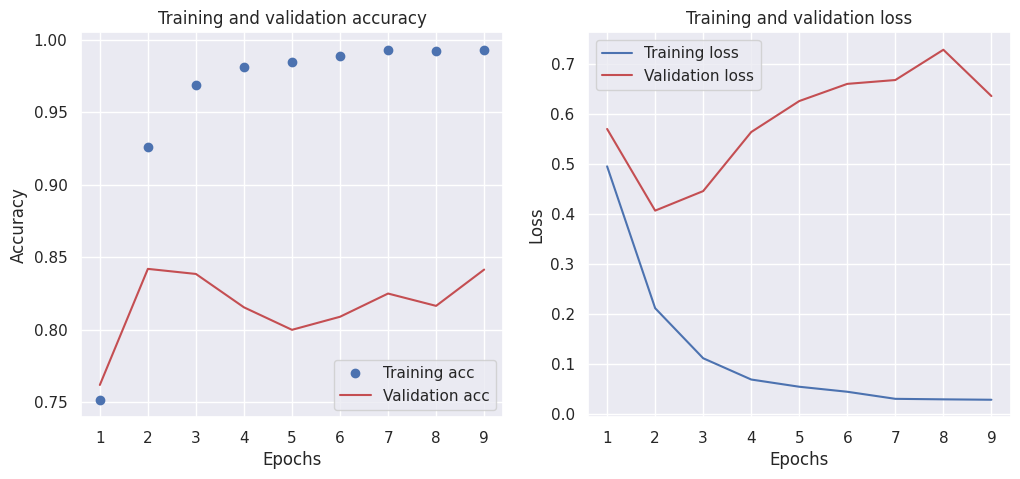

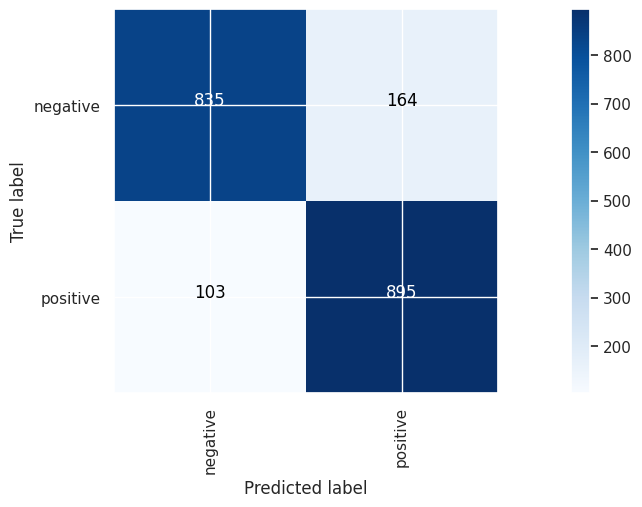

Final Accuracy
0.8662994491737607
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 gru_1 (GRU)                 (None, 8)                 1440      
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1490108 (5.68 MB)
Trainable params: 1490108 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 23s 89ms/step - loss: 0.6181 - accuracy: 0.6517 - val_loss

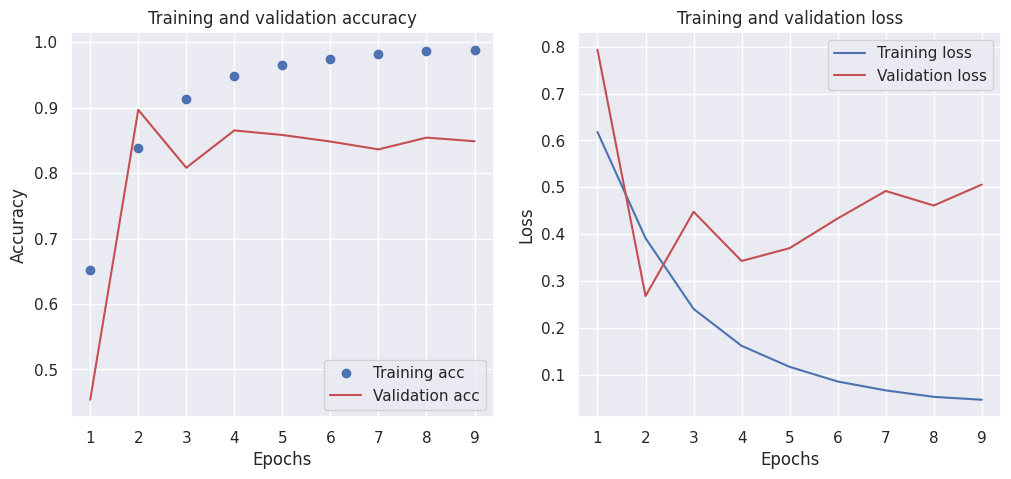

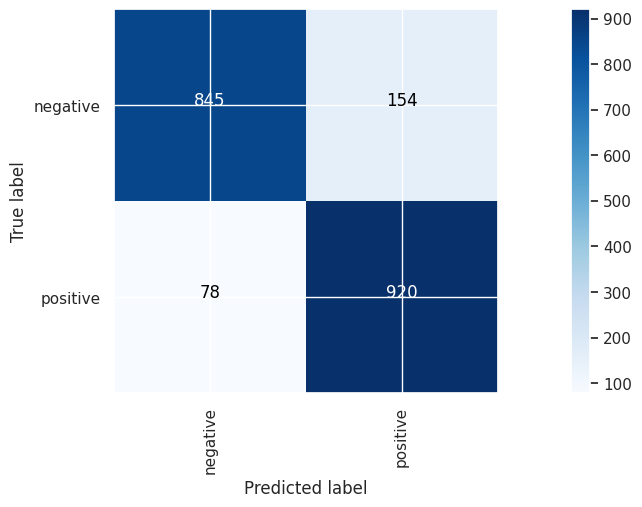

Final Accuracy
0.8838257386079119


In [10]:
results = []
name = "GRU"
description =   """
                layers_units=[8],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.0],
                recurrent_dropout=[0.0],
                make_it_bidirectional=False,
                kernel_regularizer=None
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.0]
recurrent_dropout=[0.0]
make_it_bidirectional=False
kernel_regularizer=None

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_1.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 gru_2 (GRU)                 (None, 8)                 1440      
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1490108 (5.68 MB)
Trainable params: 1490108 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 23s 85ms/step - loss: 0.5305 - accuracy: 0.7200 - val_loss: 0.5685 - val_accuracy: 0.7539
Ep

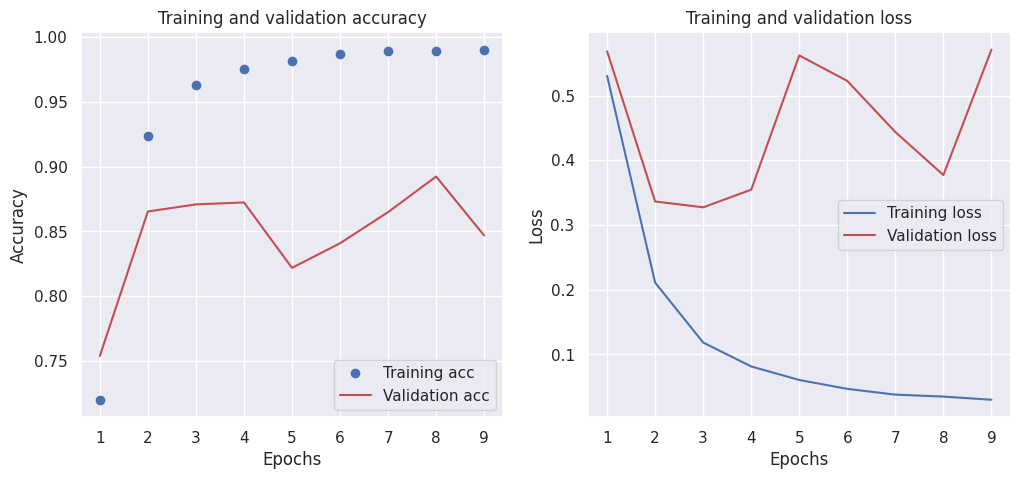

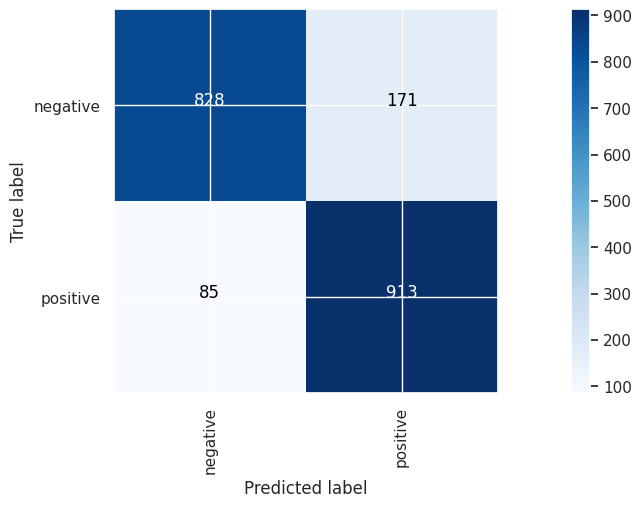

Final Accuracy
0.871807711567351
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 gru_3 (GRU)                 (None, 8)                 1440      
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1490108 (5.68 MB)
Trainable params: 1490108 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 23s 87ms/step - loss: 0.6487 - accuracy: 0.6295 - val_loss:

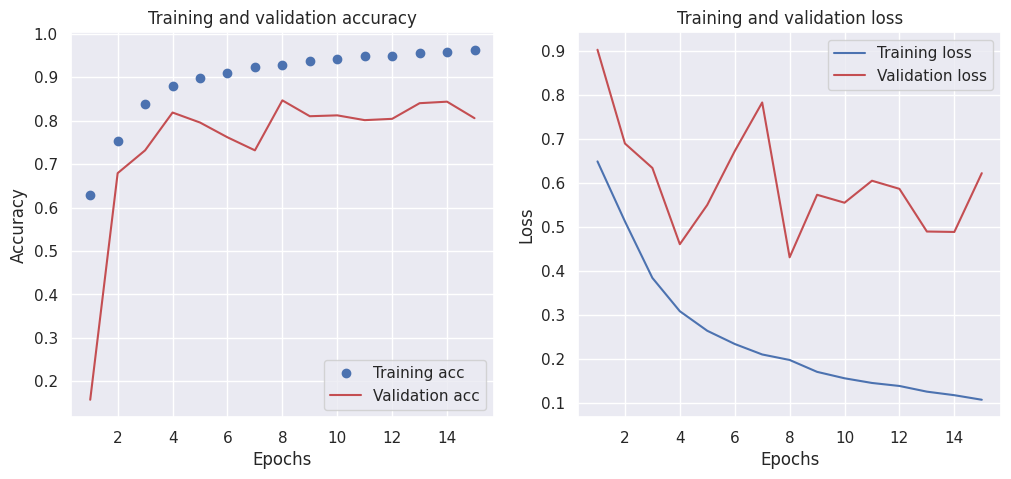

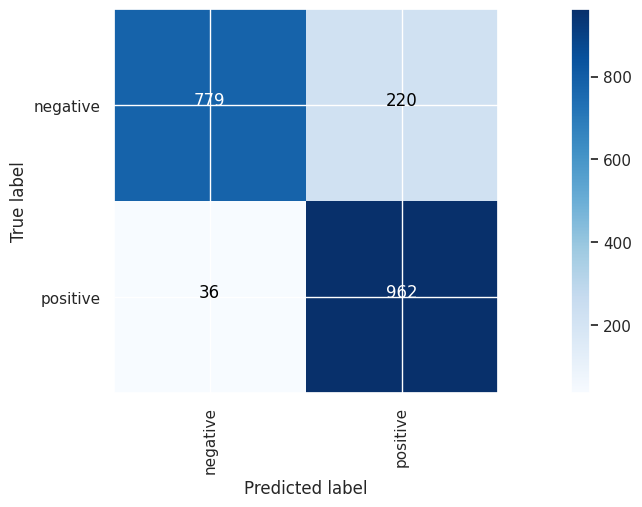

Final Accuracy
0.871807711567351


In [11]:
results = []
name = "GRU"
description =   """
                layers_units=[8],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.5],
                recurrent_dropout=[0.0],
                make_it_bidirectional=False,
                kernel_regularizer=None
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.5]
recurrent_dropout=[0.0]
make_it_bidirectional=False
kernel_regularizer=None

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_2.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 gru_5 (GRU)                 (None, 8)                 1440      
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1490108 (5.68 MB)
Trainable params: 1490108 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 22s 86ms/step - loss: 0.5142 - accuracy: 0.7344 - val_loss: 0.5264 - val_accuracy: 0.7619
Ep

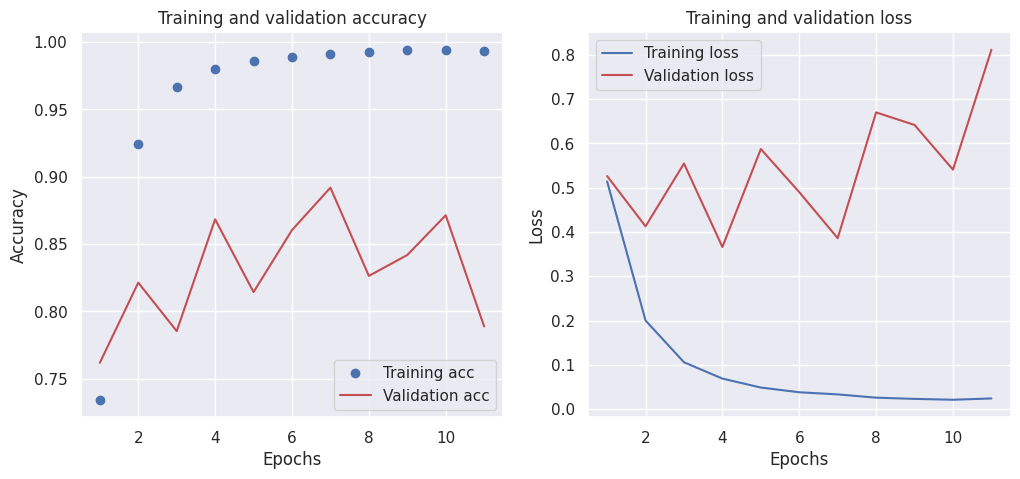

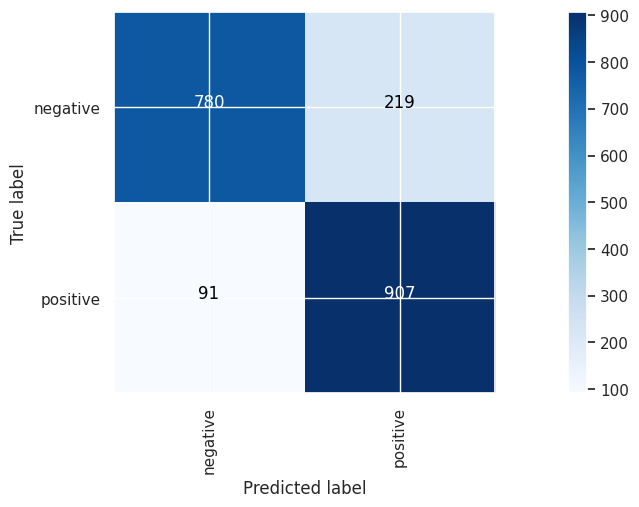

Final Accuracy
0.8447671507260891
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 gru_6 (GRU)                 (None, 8)                 1440      
                                                                 
 dense_6 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1490108 (5.68 MB)
Trainable params: 1490108 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 23s 88ms/step - loss: 0.6285 - accuracy: 0.6552 - val_loss

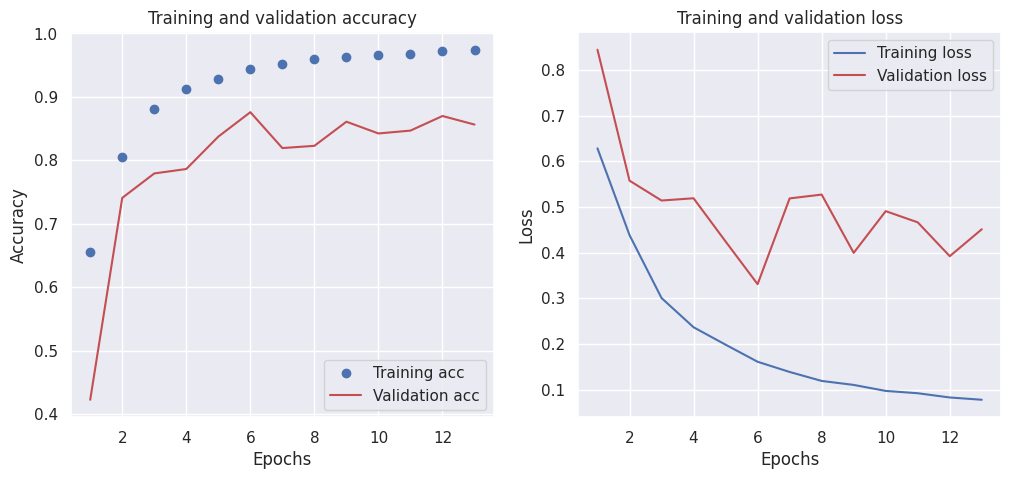

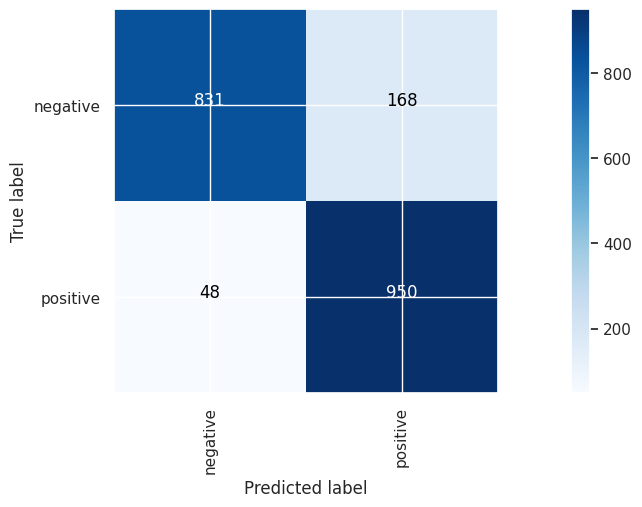

Final Accuracy
0.8918377566349525


In [13]:
results = []
name = "GRU"
description =   """
                layers_units=[8],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.3],
                recurrent_dropout=[0.0],
                make_it_bidirectional=False,
                kernel_regularizer=None
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.3]
recurrent_dropout=[0.0]
make_it_bidirectional=False
kernel_regularizer=None

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_3.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_9 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 gru_7 (GRU)                 (None, 8)                 1440      
                                                                 
 dense_7 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1490108 (5.68 MB)
Trainable params: 1490108 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 23s 88ms/step - loss: 0.7190 - accuracy: 0.6698 - val_loss: 0.7768 - val_accuracy: 0.6588
Ep

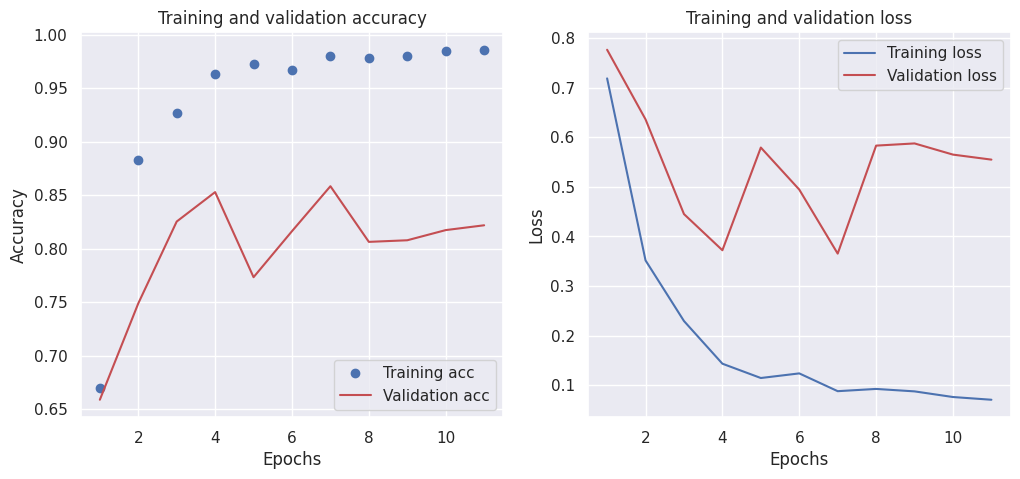

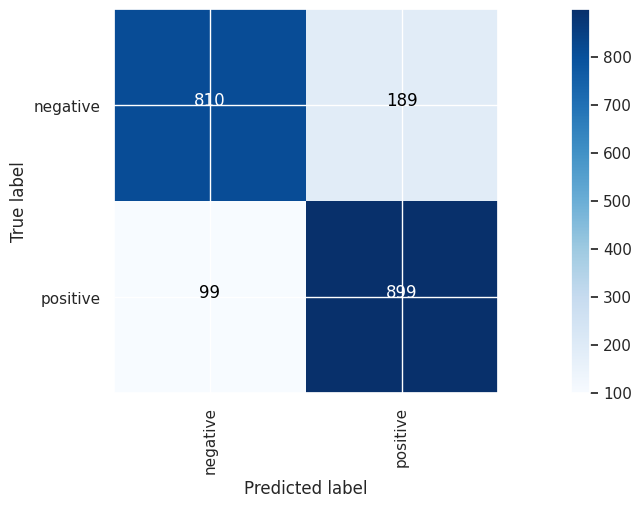

Final Accuracy
0.85578367551327
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_10 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 gru_8 (GRU)                 (None, 8)                 1440      
                                                                 
 dense_8 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1490108 (5.68 MB)
Trainable params: 1490108 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 23s 89ms/step - loss: 0.8088 - accuracy: 0.6220 - val_loss: 

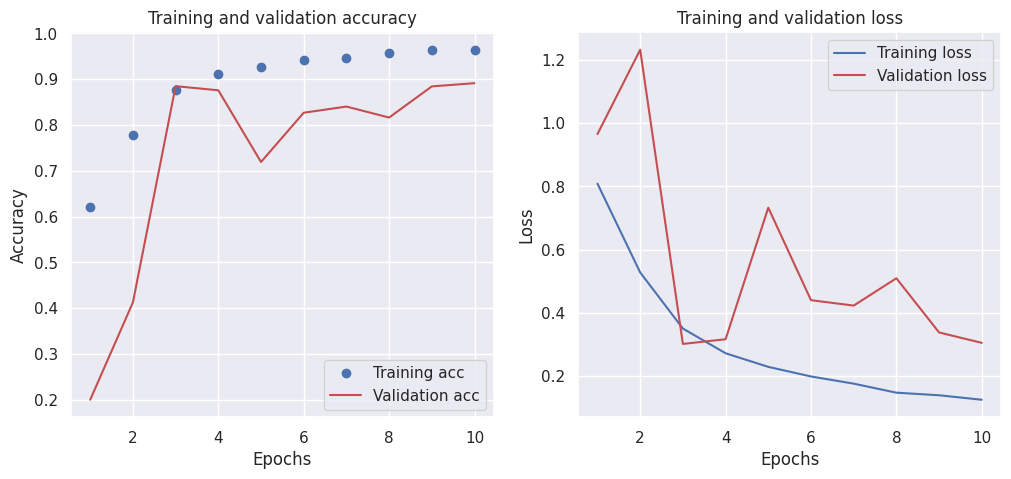

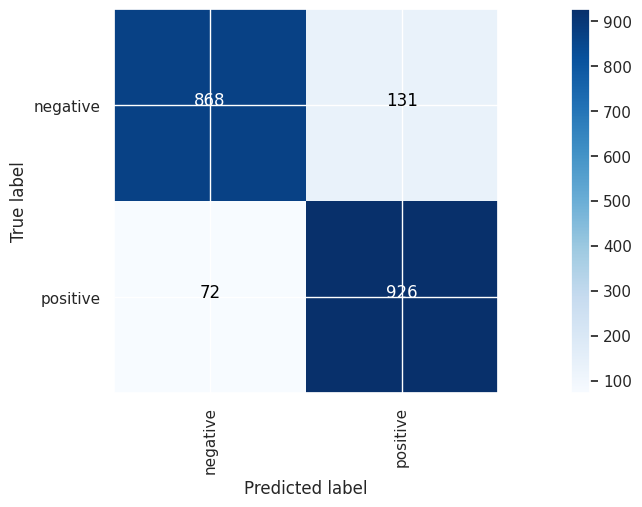

Final Accuracy
0.8983475212819229


In [14]:
results = []
name = "GRU"
description =   """
                layers_units=[8],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.3],
                recurrent_dropout=[0.0],
                make_it_bidirectional=False,
                kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.3]
recurrent_dropout=[0.0]
make_it_bidirectional=False
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_4.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_11 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional (Bidirection  (None, 16)                2880      
 al)                                                             
                                                                 
 dense_9 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1491564 (5.69 MB)
Trainable params: 1491564 (5.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 28s 108ms/step - loss: 0.5

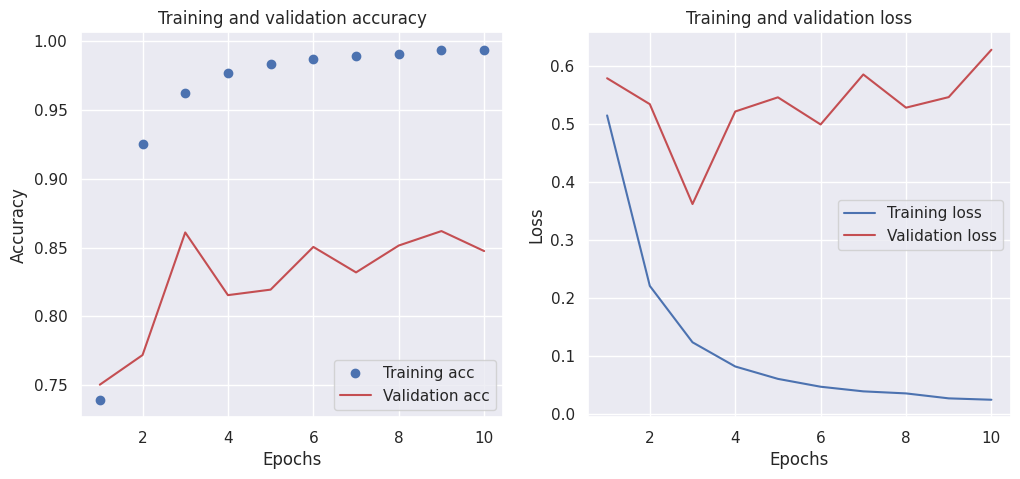

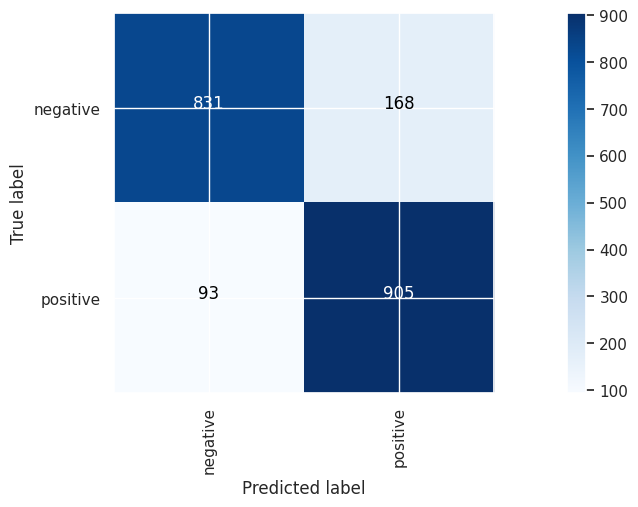

Final Accuracy
0.8693039559339009
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_12 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_1 (Bidirecti  (None, 16)                2880      
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 2)                 34        
                                                                 
Total params: 1491564 (5.69 MB)
Trainable params: 1491564 (5.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==========================

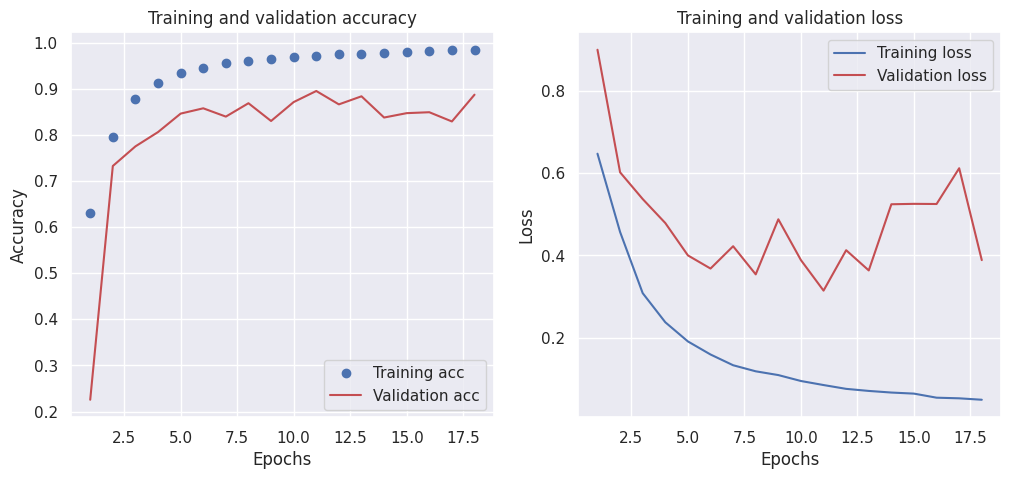

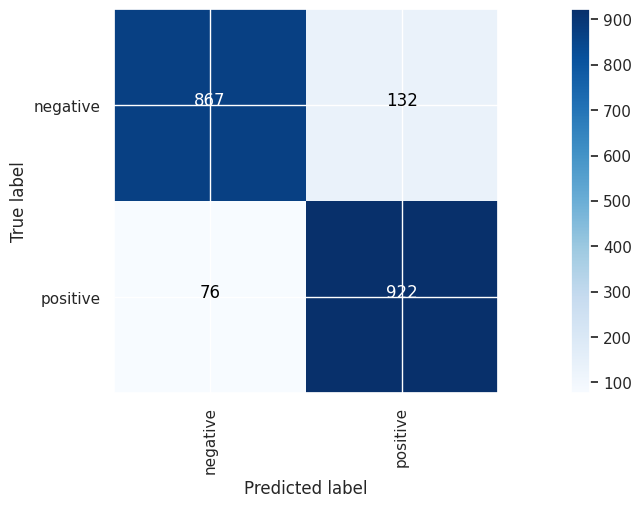

Final Accuracy
0.8958437656484727


In [15]:
results = []
name = "GRU"
description =   """
                layers_units=[8],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.3],
                recurrent_dropout=[0.0],
                make_it_bidirectional=True,
                kernel_regularizer=kernel_regularizer=None
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.3]
recurrent_dropout=[0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=None

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_5.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_13 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_2 (Bidirecti  (None, 16)                2880      
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 64)                1088      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 2)                 130       
                                                         

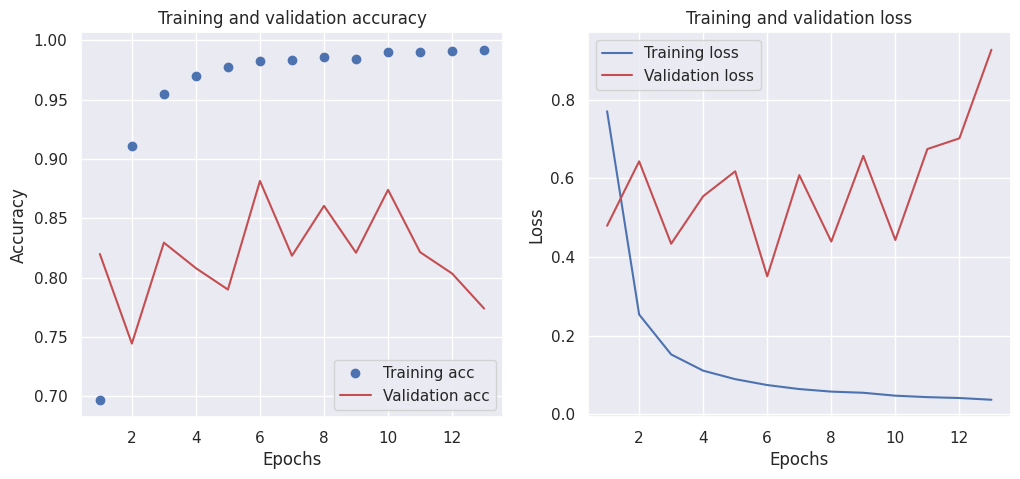

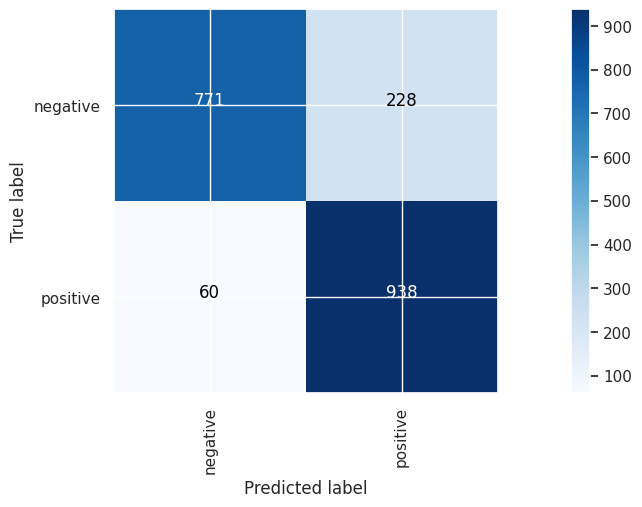

Final Accuracy
0.85578367551327
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_14 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_3 (Bidirecti  (None, 16)                2880      
 onal)                                                           
                                                                 
 dense_13 (Dense)            (None, 64)                1088      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 2)                 130       
                         

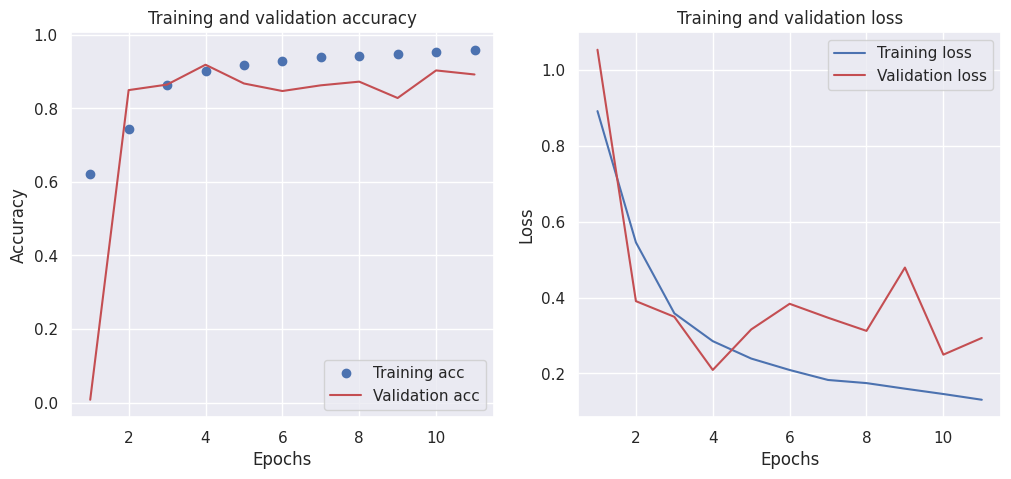

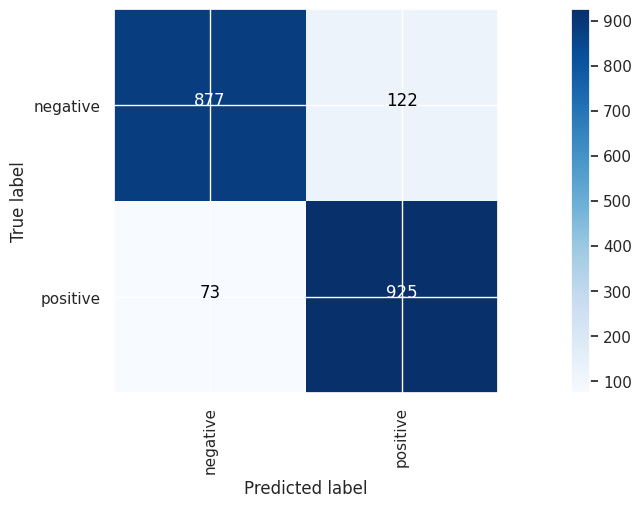

Final Accuracy
0.9023535302954432


In [16]:
results = []
name = "GRU"
description =   """
                layers_units=[8],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.5],
                recurrent_dropout=[0.0],
                make_it_bidirectional=True,
                kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8]
extra_dense_layer_nn=64
extra_dense_dropout_layer=0.4
dropout=[0.5]
recurrent_dropout=[0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_6.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_15 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_4 (Bidirecti  (None, 600, 16)           2880      
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 32)                3264      
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1494860 (5.70 MB)
Trainable params: 1494860

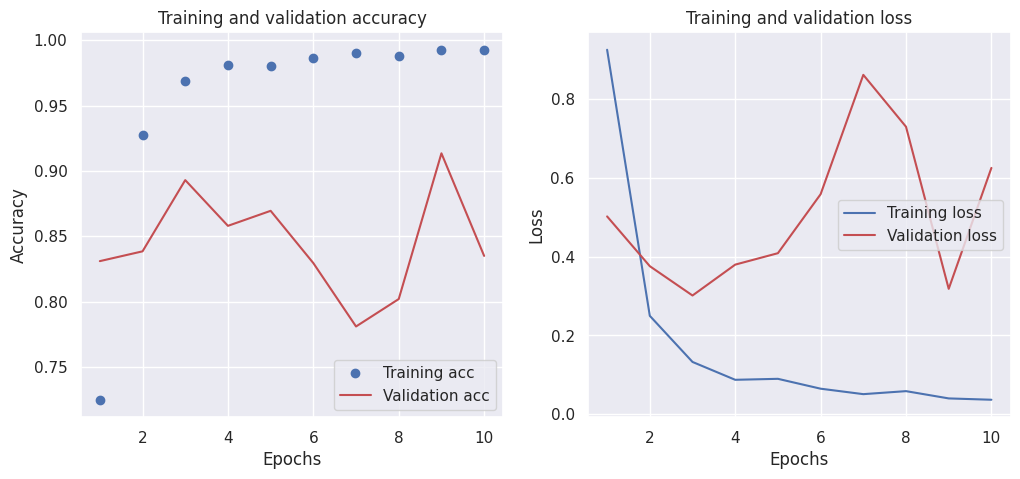

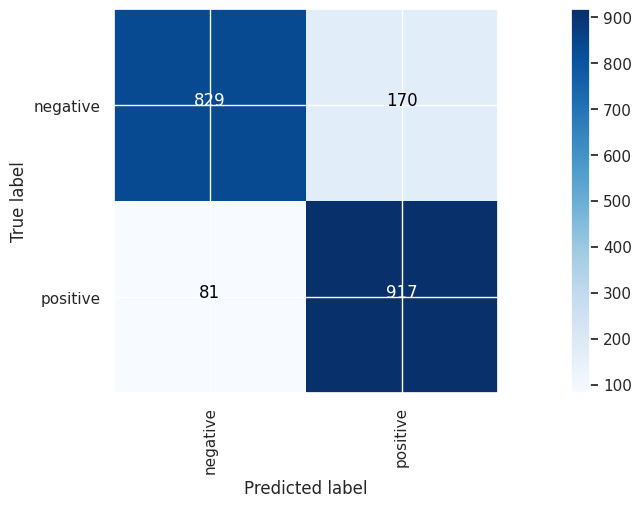

Final Accuracy
0.8743114672008012
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_16 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_6 (Bidirecti  (None, 32)                6528      
 onal)                                                           
                                                                 
 dense_16 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1495244 (5.70 MB)
Trainable params: 1495244 (5.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==========================

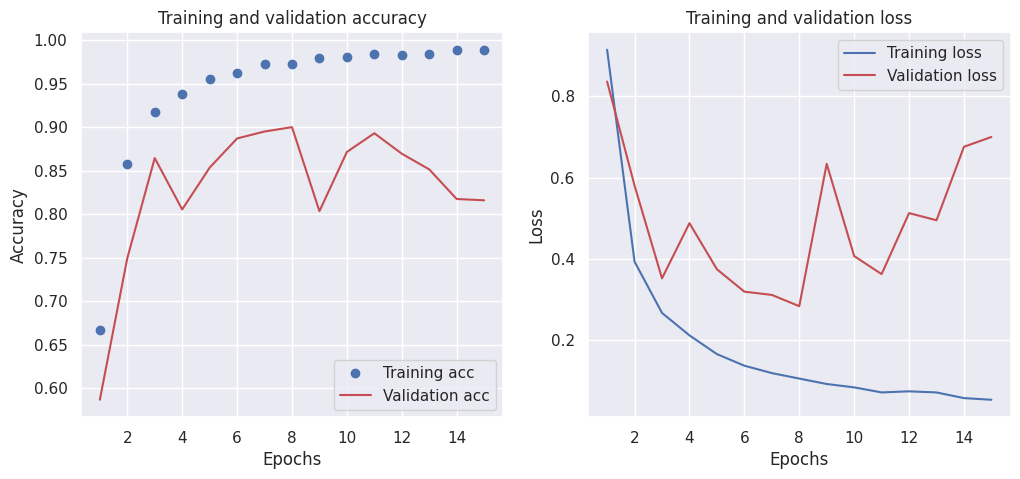

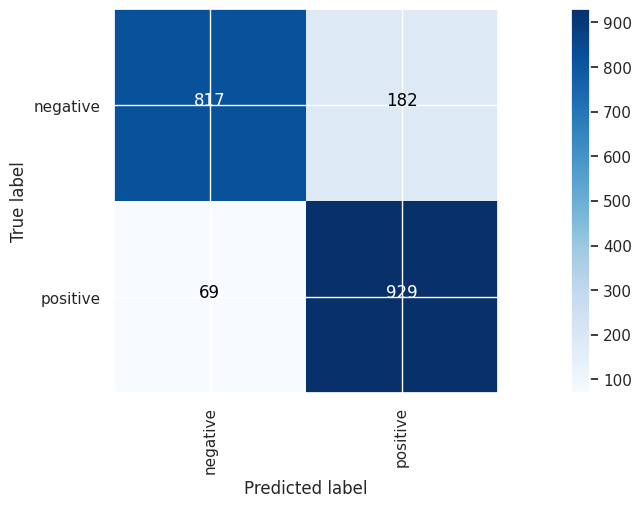

Final Accuracy
0.8743114672008012


In [17]:
results = []
name = "GRU"
description =   """
                layers_units=[8,16],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.1,0.4],
                recurrent_dropout=[0.0,0.0],
                make_it_bidirectional=True,
                kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8,16]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.1,0.4]
recurrent_dropout=[0.0,0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_7.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_17 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_7 (Bidirecti  (None, 600, 16)           2880      
 onal)                                                           
                                                                 
 bidirectional_8 (Bidirecti  (None, 600, 32)           3264      
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 64)                12672     
 onal)                                                           
                                                         

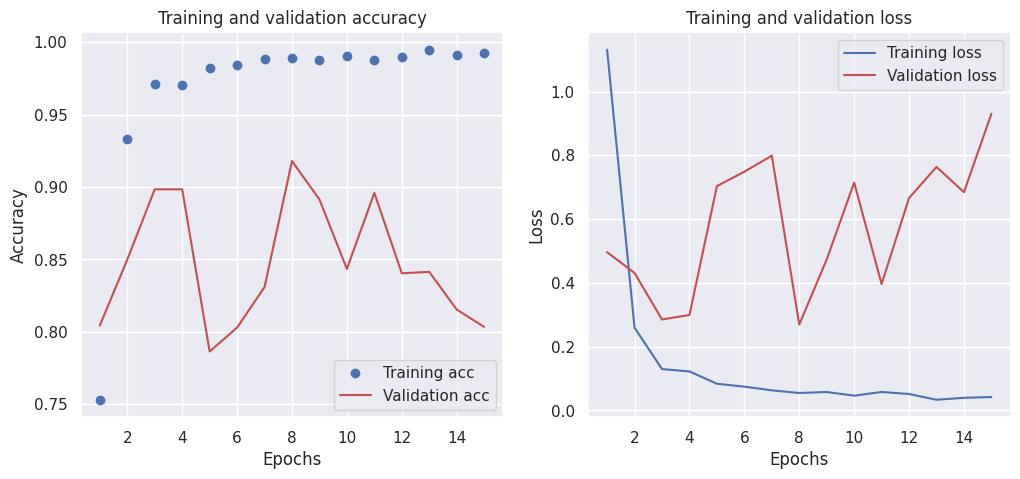

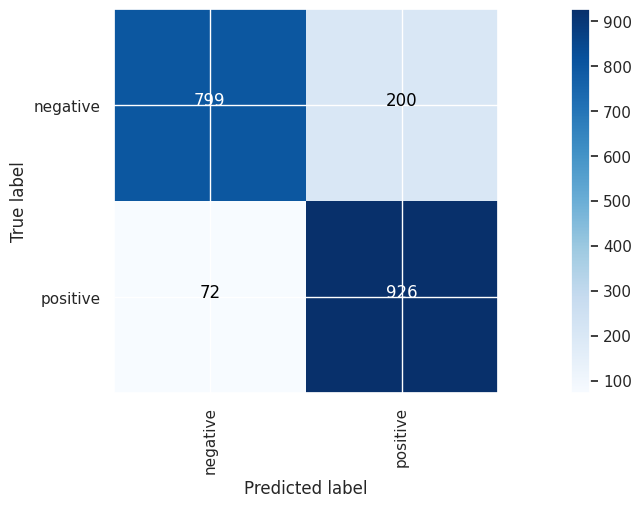

Final Accuracy
0.8637956935403105
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_18 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_10 (Bidirect  (None, 600, 32)           6528      
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 64)                12672     
 ional)                                                          
                                                                 
 dense_18 (Dense)            (None, 2)                 130       
                                                                 
Total params: 1507980 (

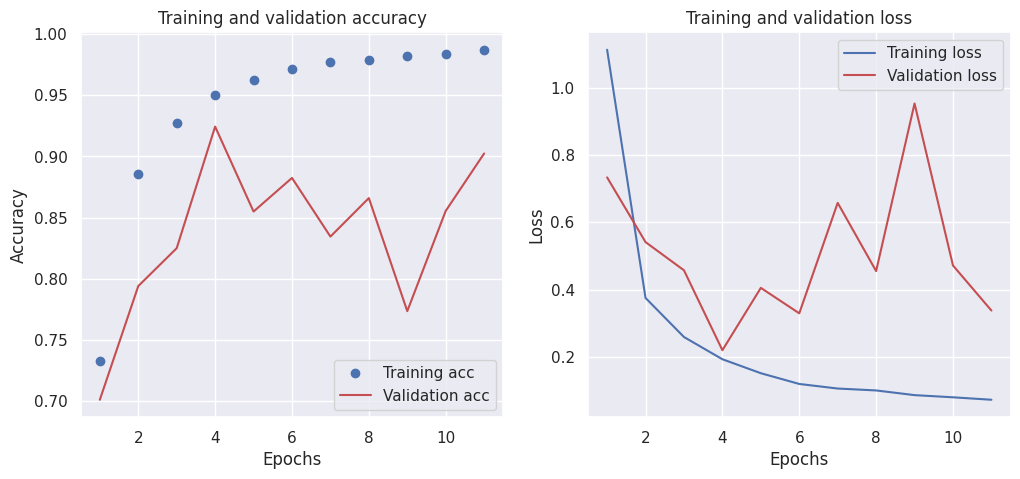

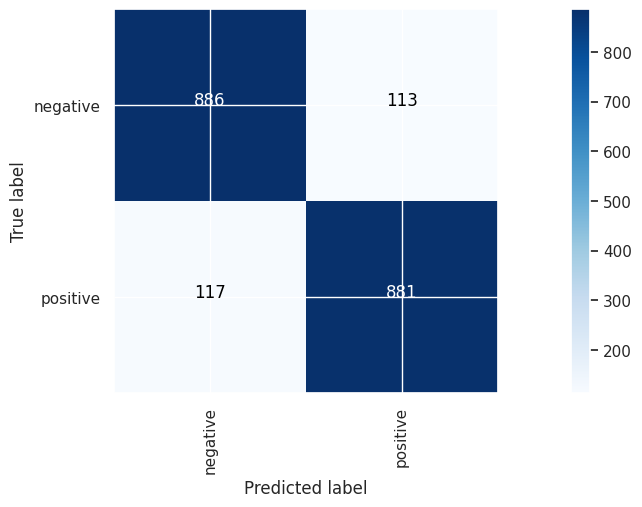

Final Accuracy
0.8848272408612919


In [18]:
results = []
name = "GRU"
description =   """
                layers_units=[8,16,32],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.0,0.2,0.5],
                recurrent_dropout=[0.0,0.0,0.0],
                make_it_bidirectional=True,
                kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8,16,32]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.0,0.2,0.5]
recurrent_dropout=[0.0,0.0,0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_8.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_19 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_12 (Bidirect  (None, 600, 16)           2880      
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, 600, 32)           3264      
 ional)                                                          
                                                                 
 bidirectional_14 (Bidirect  (None, 64)                12672     
 ional)                                                          
                                                         

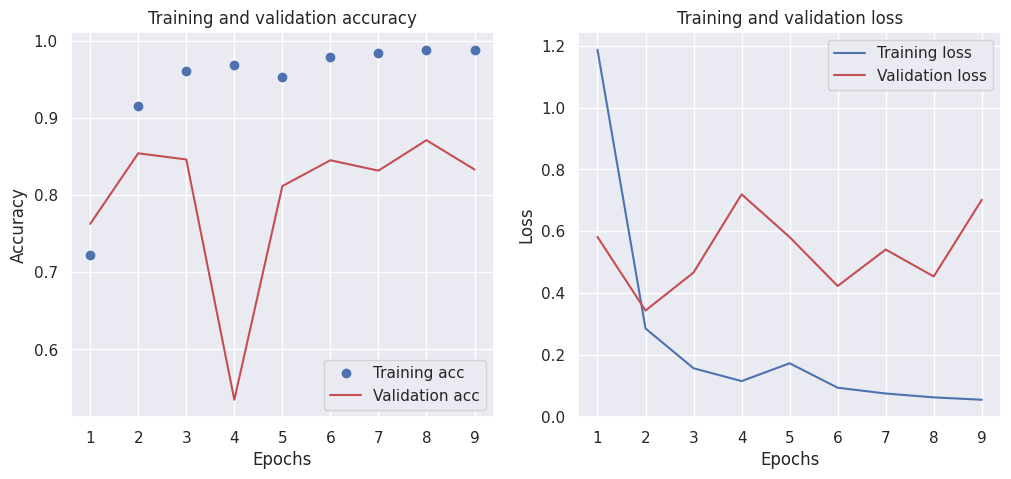

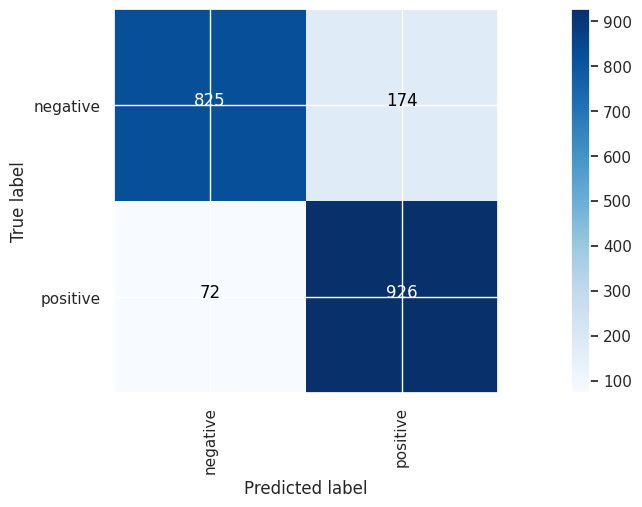

Final Accuracy
0.8768152228342514
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_20 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_15 (Bidirect  (None, 600, 32)           6528      
 ional)                                                          
                                                                 
 bidirectional_16 (Bidirect  (None, 64)                12672     
 ional)                                                          
                                                                 
 dense_20 (Dense)            (None, 2)                 130       
                                                                 
Total params: 1507980 (

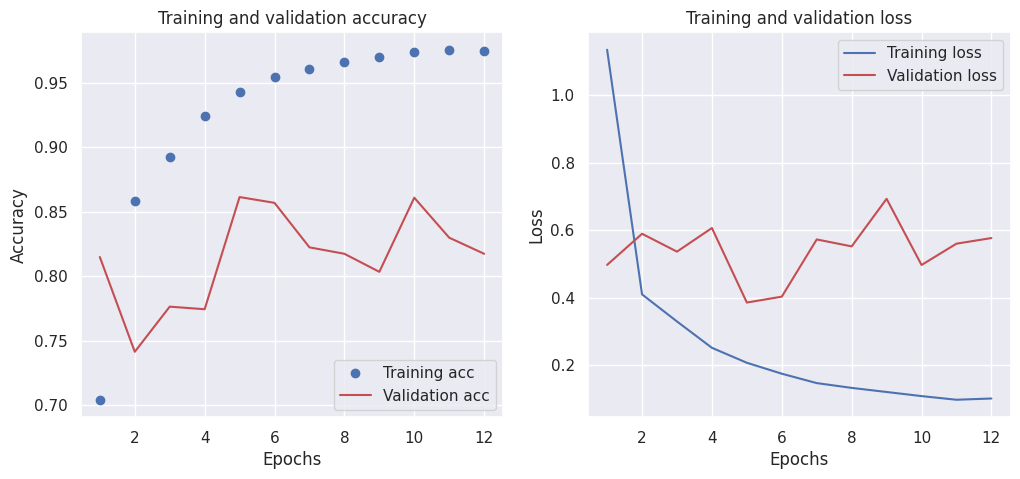

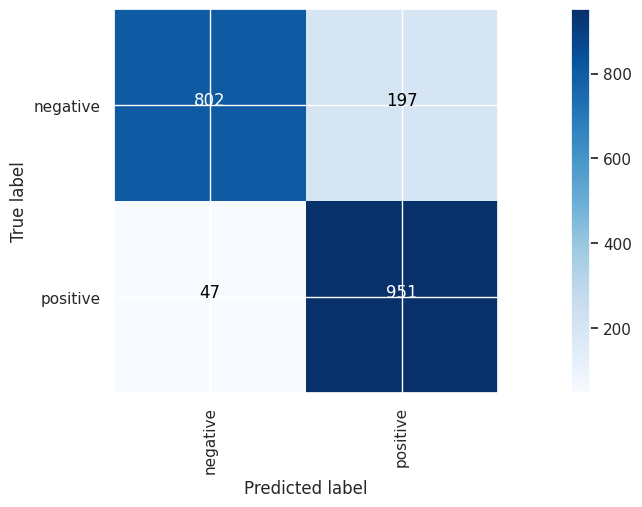

Final Accuracy
0.8778167250876314


In [19]:
results = []
name = "GRU"
description =   """
                layers_units=[8,16,32],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.3,0.3,0.4],
                recurrent_dropout=[0.0,0.0,0.0],
                make_it_bidirectional=True,
                kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8,16,32]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.3,0.3,0.4]
recurrent_dropout=[0.0,0.0,0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_9.csv", index=False)

In [20]:
results = []
name = "GRU"
description =   """
                layers_units=[8,16,32],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.0,0.2,0.2],
                recurrent_dropout=[0.0,0.0,0.0],
                make_it_bidirectional=True,
                kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8,16,32]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.0,0.2,0.2]
recurrent_dropout=[0.0,0.0,0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_10.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_21 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_17 (Bidirect  (None, 600, 16)           2880      
 ional)                                                          
                                                                 
 bidirectional_18 (Bidirect  (None, 600, 32)           3264      
 ional)                                                          
                                                                 
 bidirectional_19 (Bidirect  (None, 64)                12672     
 ional)                                                          
                                                         

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_23 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_22 (Bidirect  (None, 256)               138240    
 ional)                                                          
                                                                 
 dense_23 (Dense)            (None, 2)                 514       
                                                                 
Total params: 1627404 (6.21 MB)
Trainable params: 1627404 (6.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 29s 111ms/step - loss: 0.7

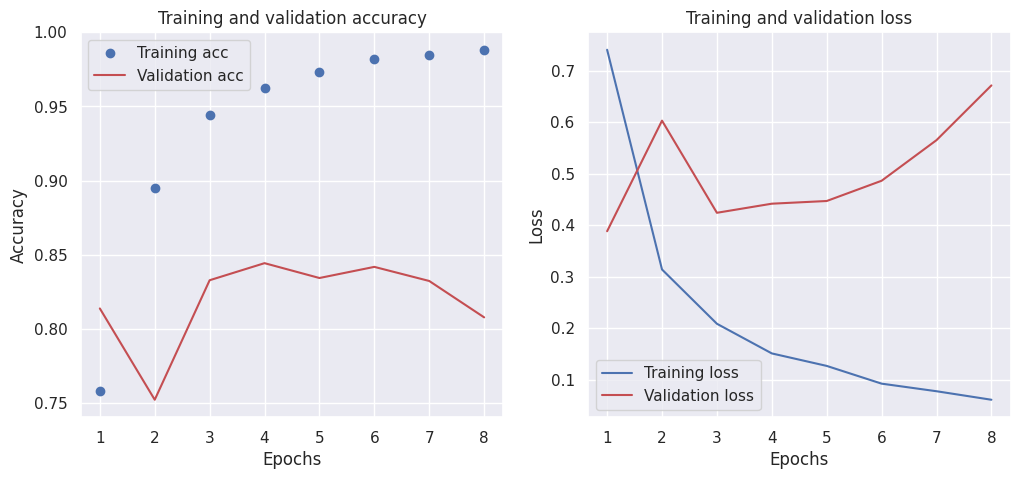

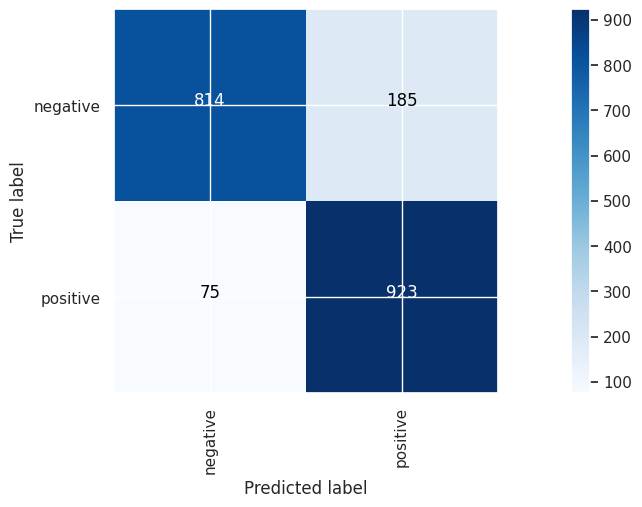

Final Accuracy
0.8698047070605909
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_24 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_23 (Bidirect  (None, 256)               138240    
 ional)                                                          
                                                                 
 dense_24 (Dense)            (None, 2)                 514       
                                                                 
Total params: 1627404 (6.21 MB)
Trainable params: 1627404 (6.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==========================

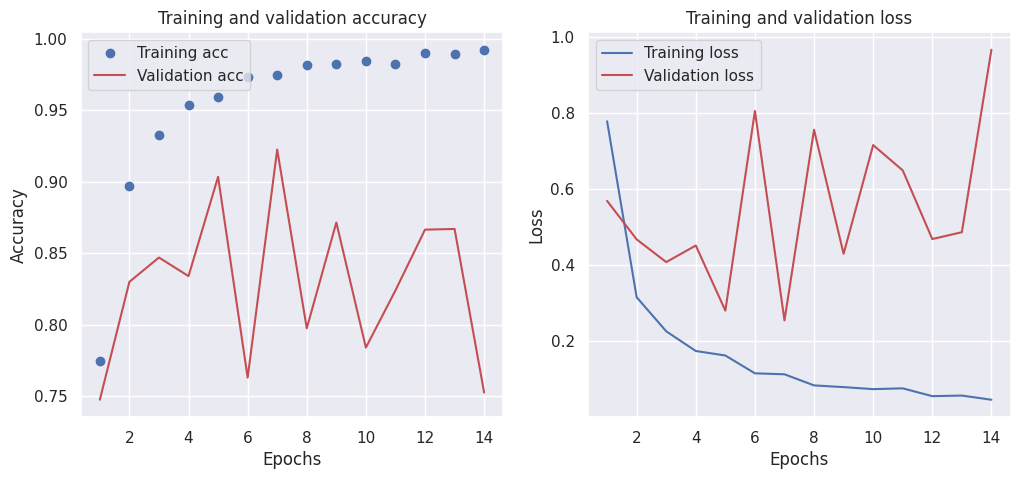

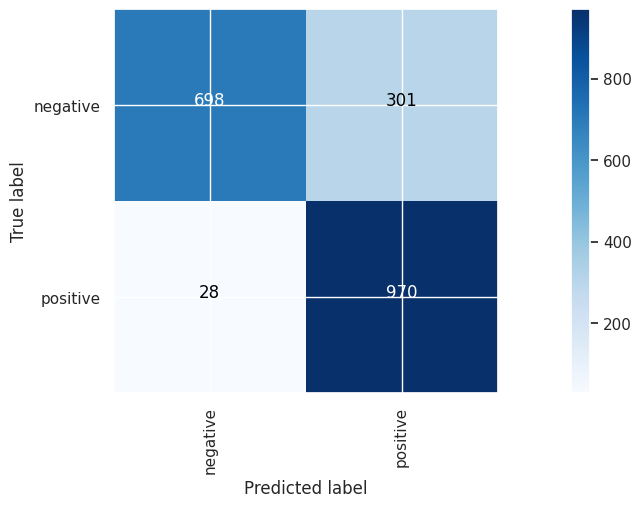

Final Accuracy
0.8352528793189785


In [21]:
results = []
name = "GRU"
description =   """
                layers_units=[128],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.0],
                recurrent_dropout=[0.0,0.0],
                make_it_bidirectional=True,
                kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[128]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.0]
recurrent_dropout=[0.0,0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_11.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_25 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 gru_33 (GRU)                (None, 128)               69120     
                                                                 
 dense_25 (Dense)            (None, 2)                 258       
                                                                 
Total params: 1558028 (5.94 MB)
Trainable params: 1558028 (5.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 23s 89ms/step - loss: 0.6370 - accuracy: 0.7664 - val_loss: 0.5760 - val_accuracy: 0.7259
Ep

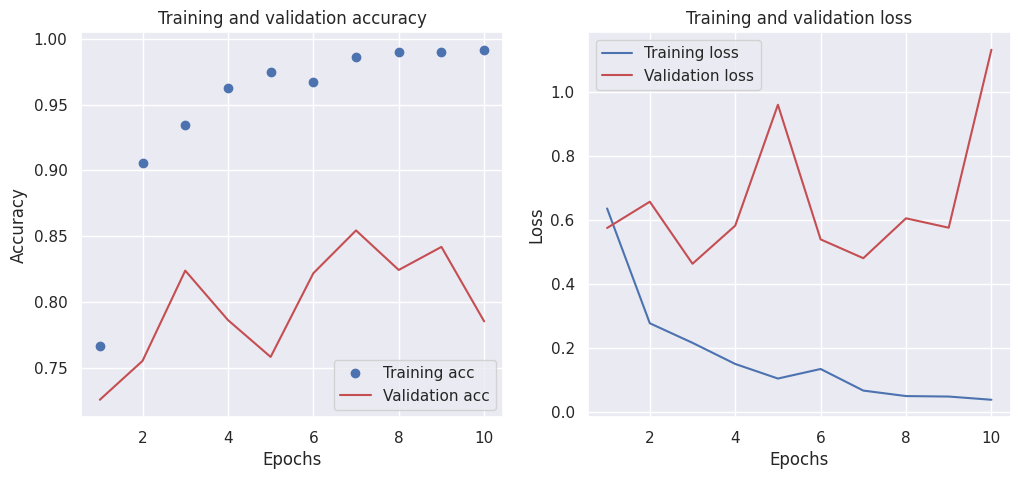

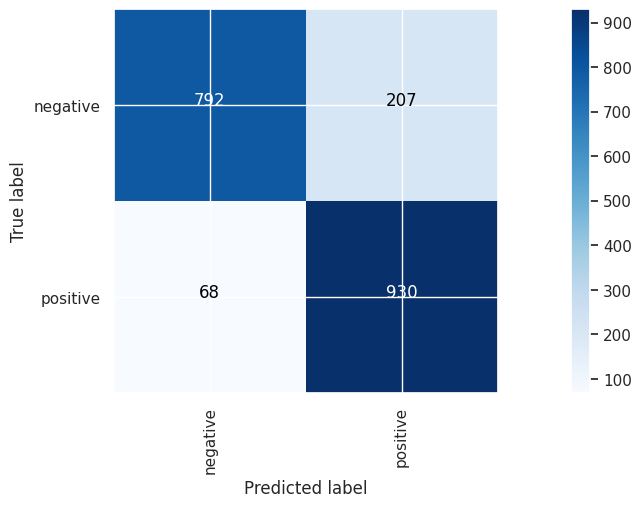

Final Accuracy
0.8622934401602403
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_26 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 gru_34 (GRU)                (None, 128)               69120     
                                                                 
 dense_26 (Dense)            (None, 2)                 258       
                                                                 
Total params: 1558028 (5.94 MB)
Trainable params: 1558028 (5.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 24s 92ms/step - loss: 0.6345 - accuracy: 0.7970 - val_loss

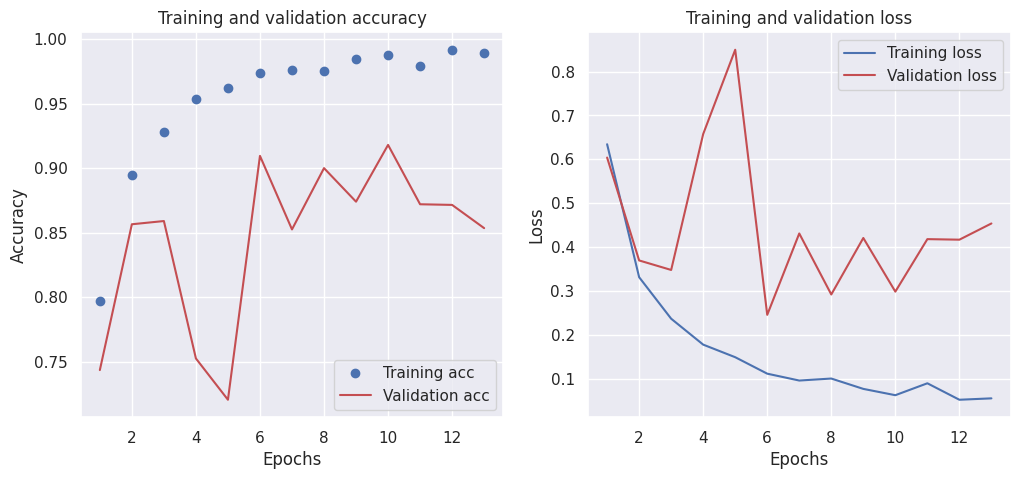

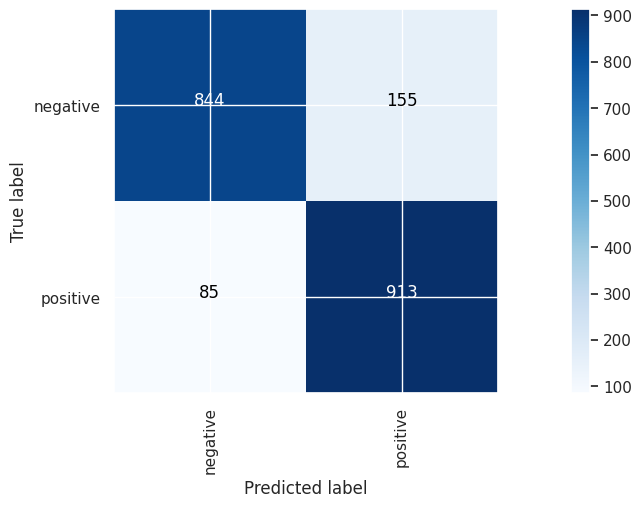

Final Accuracy
0.8798197295943916


In [22]:
results = []
name = "GRU"
description =   """
                layers_units=[128],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.0],
                recurrent_dropout=[0.0,0.0],
                make_it_bidirectional=False,
                kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[128]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.0]
recurrent_dropout=[0.0,0.0]
make_it_bidirectional=False
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_11.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_27 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 gru_35 (GRU)                (None, 128)               69120     
                                                                 
 dense_27 (Dense)            (None, 2)                 258       
                                                                 
Total params: 1558028 (5.94 MB)
Trainable params: 1558028 (5.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 23s 89ms/step - loss: 0.4639 - accuracy: 0.7732 - val_loss: 0.3189 - val_accuracy: 0.8524
Ep

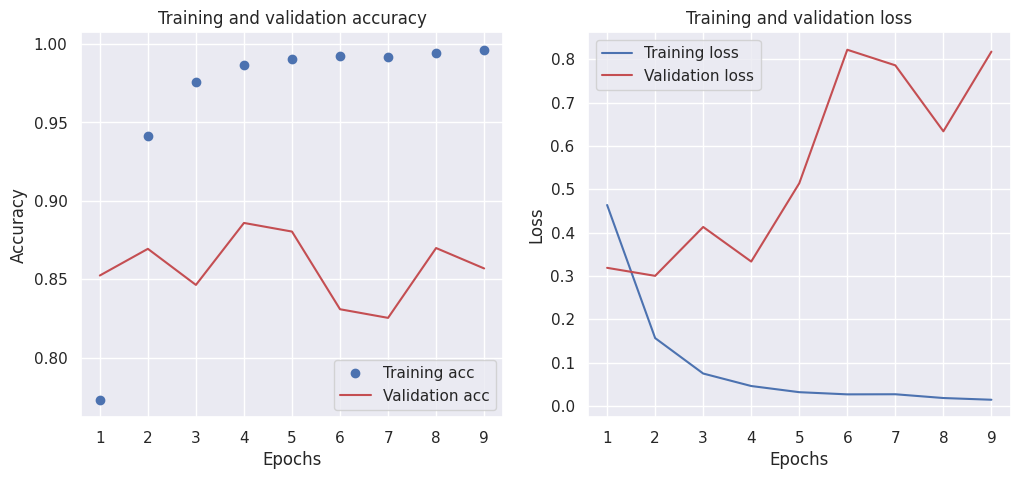

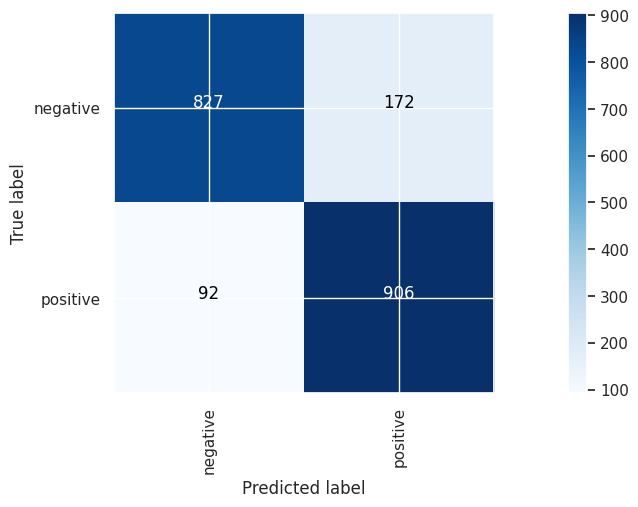

Final Accuracy
0.8678017025538307
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_28 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 gru_36 (GRU)                (None, 128)               69120     
                                                                 
 dense_28 (Dense)            (None, 2)                 258       
                                                                 
Total params: 1558028 (5.94 MB)
Trainable params: 1558028 (5.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 25s 93ms/step - loss: 0.4472 - accuracy: 0.7866 - val_loss

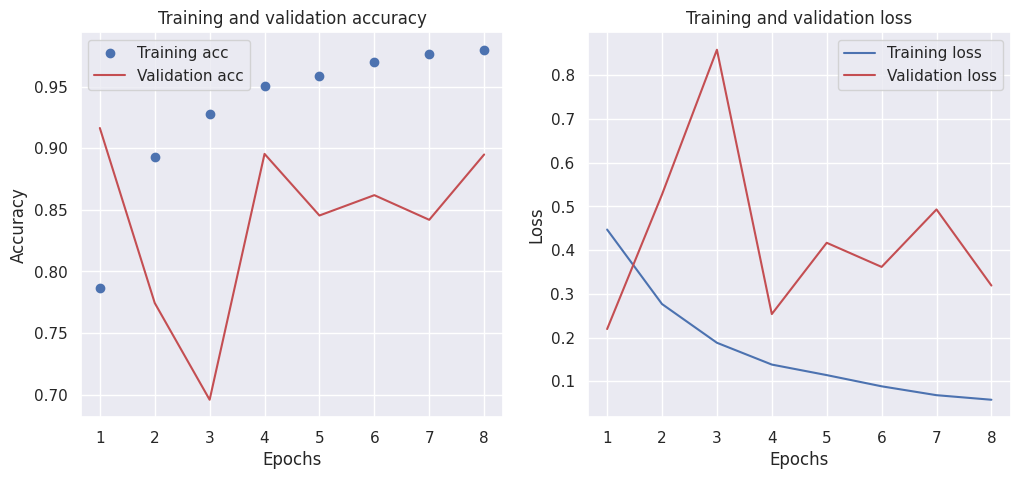

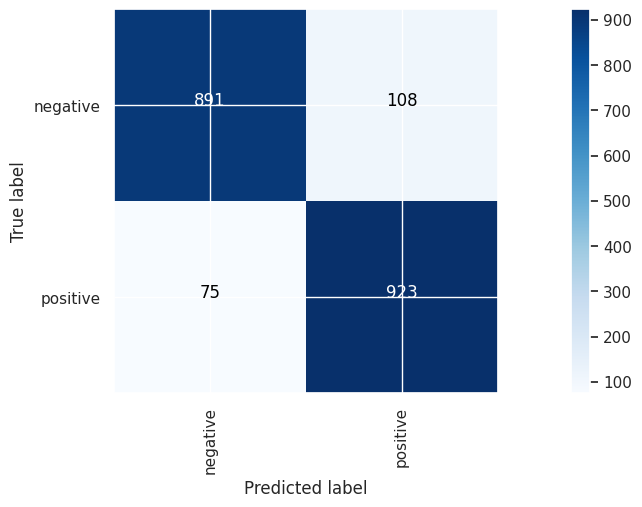

Final Accuracy
0.9083625438157236


In [23]:
results = []
name = "GRU"
description =   """
                layers_units=[128],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.15],
                recurrent_dropout=[0.0],
                make_it_bidirectional=False,
                kernel_regularizer=kernel_regularizer=None
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[128]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.15]
recurrent_dropout=[0.0]
make_it_bidirectional=False
kernel_regularizer=kernel_regularizer=None

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_12.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_29 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 gru_37 (GRU)                (None, 64)                22272     
                                                                 
 dense_29 (Dense)            (None, 2)                 130       
                                                                 
Total params: 1511052 (5.76 MB)
Trainable params: 1511052 (5.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 23s 89ms/step - loss: 0.6794 - accuracy: 0.7459 - val_loss: 0.5406 - val_accuracy: 0.7974
Ep

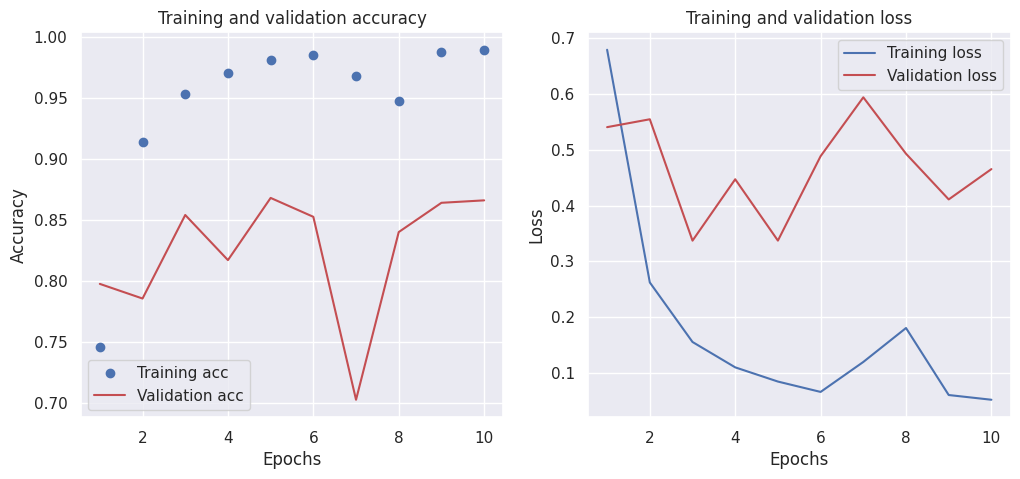

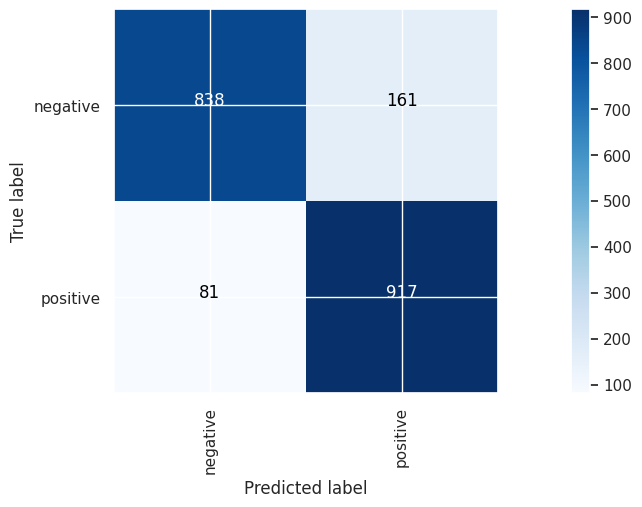

Final Accuracy
0.8788182273410116
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_30 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 gru_38 (GRU)                (None, 64)                22272     
                                                                 
 dense_30 (Dense)            (None, 2)                 130       
                                                                 
Total params: 1511052 (5.76 MB)
Trainable params: 1511052 (5.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 23s 90ms/step - loss: 0.7294 - accuracy: 0.7359 - val_loss

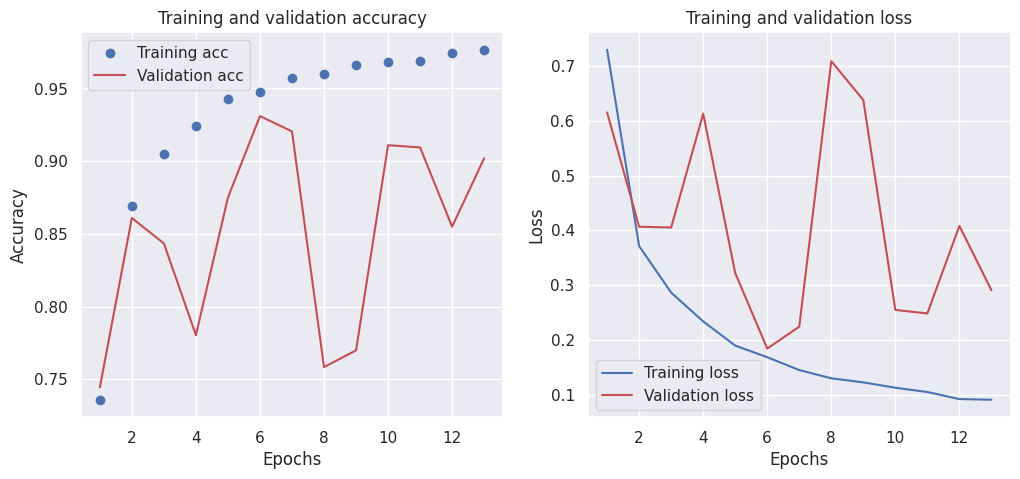

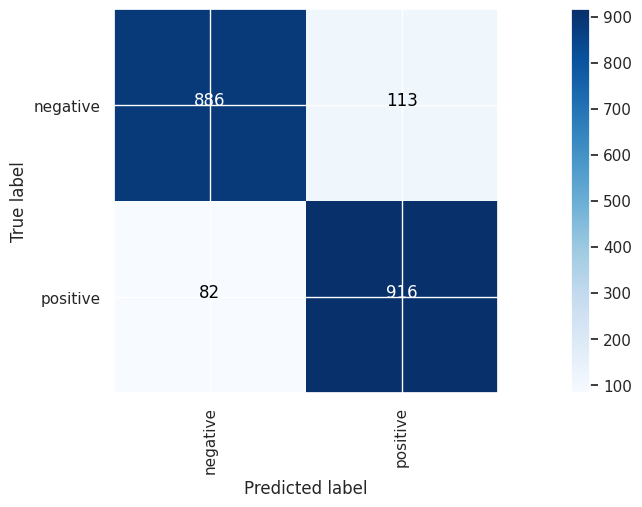

Final Accuracy
0.9023535302954432


In [24]:
results = []
name = "GRU"
description =   """
                layers_units=[64],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.3],
                recurrent_dropout=[0.0],
                make_it_bidirectional=False,
                kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[64]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.3]
recurrent_dropout=[0.0]
make_it_bidirectional=False
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_13.csv", index=False)

Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 gru_39 (GRU)                (None, 64)                12864     
                                                                 
 dense_31 (Dense)            (None, 2)                 130       
                                                                 
Total params: 12994 (50.76 KB)
Trainable params: 12994 (50.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 38s 148ms/step - loss: 0.6640 - accuracy: 0.6248 - val_loss: 0.9222 - val_accuracy: 0.0000e+00
Epoch 2/40
250/250 [==============================] - 37s 150ms/step - loss: 0.6628 - accuracy: 0.6250 - val_loss: 0.9682 - val_acc

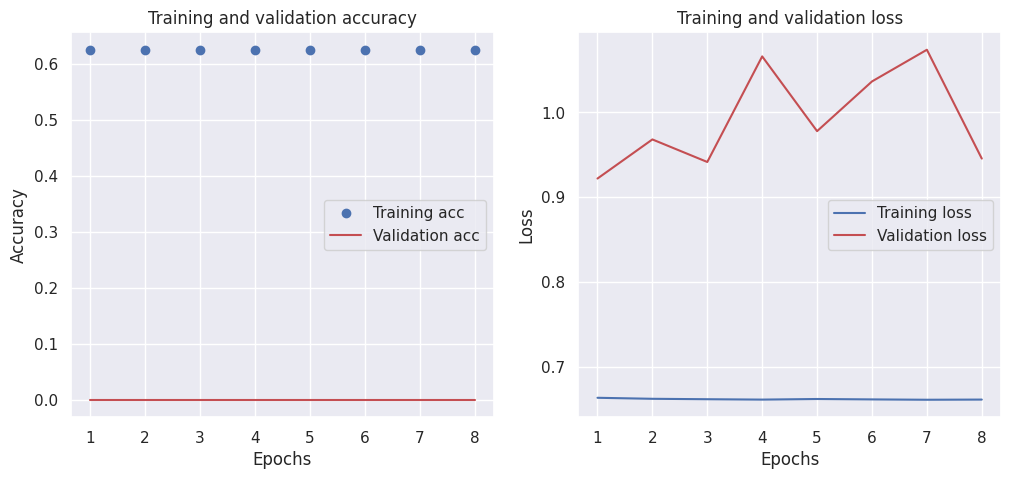

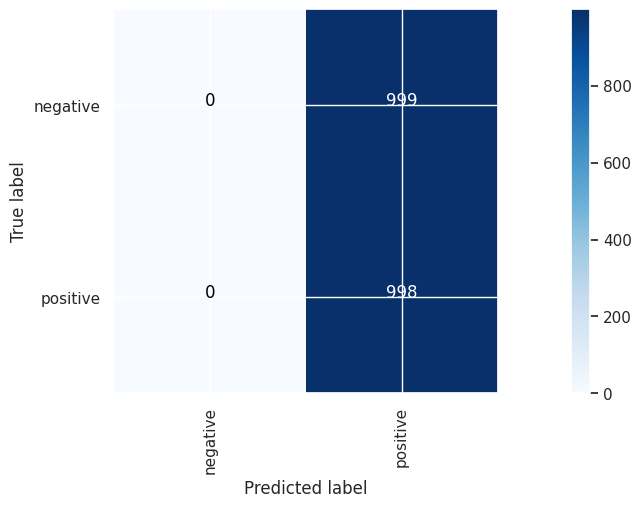

Final Accuracy
0.499749624436655
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 gru_40 (GRU)                (None, 64)                12864     
                                                                 
 dense_32 (Dense)            (None, 2)                 130       
                                                                 
Total params: 12994 (50.76 KB)
Trainable params: 12994 (50.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 38s 147ms/step - loss: 0.6650 - accuracy: 0.6250 - val_loss: 1.0080 - val_accuracy: 0.0000e+00
Epoch 2/40
250/250 [==============================] - 35s 140ms/step - loss: 0.6629 - accuracy: 0.

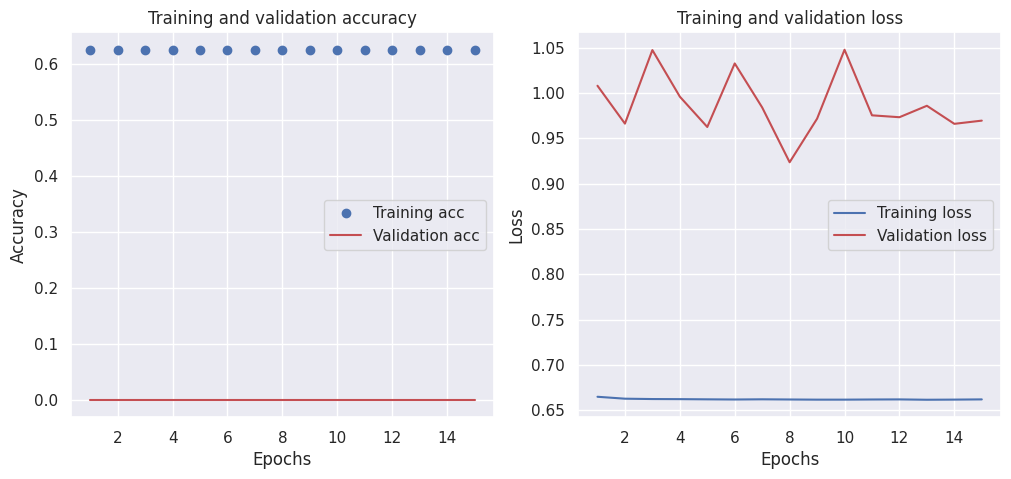

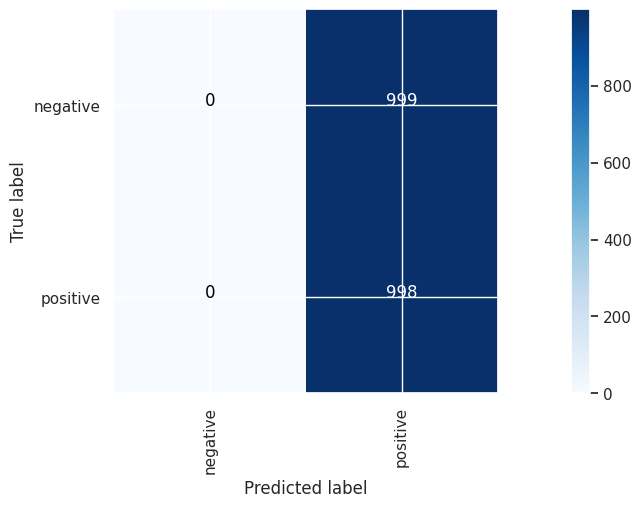

Final Accuracy
0.499749624436655
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 gru_41 (GRU)                (None, 64)                12864     
                                                                 
 dense_33 (Dense)            (None, 2)                 130       
                                                                 
Total params: 12994 (50.76 KB)
Trainable params: 12994 (50.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 39s 153ms/step - loss: 0.6636 - accuracy: 0.6248 - val_loss: 0.9829 - val_accuracy: 0.0000e+00
Epoch 2/40
250/250 [==============================] - 38s 152ms/step - loss: 0.6628 - accuracy: 0.

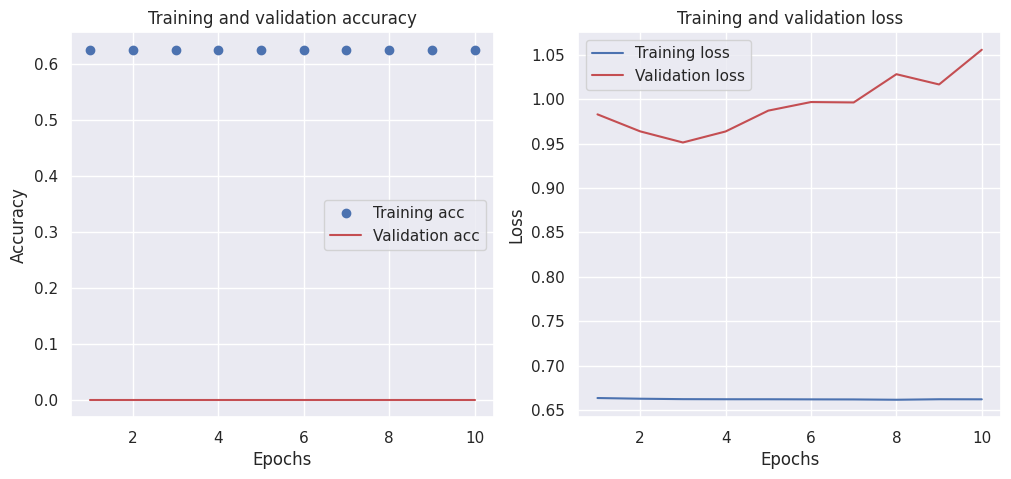

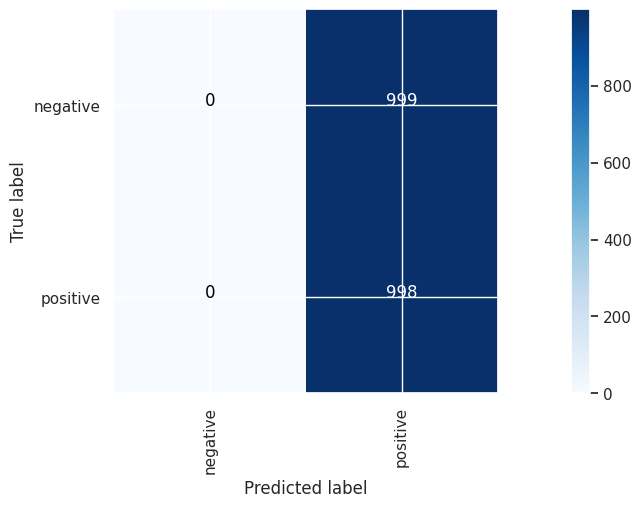

Final Accuracy
0.499749624436655
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 gru_42 (GRU)                (None, 64)                12864     
                                                                 
 dense_34 (Dense)            (None, 2)                 130       
                                                                 
Total params: 12994 (50.76 KB)
Trainable params: 12994 (50.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 38s 150ms/step - loss: 0.6635 - accuracy: 0.6242 - val_loss: 1.0528 - val_accuracy: 0.0000e+00
Epoch 2/40
250/250 [==============================] - 38s 150ms/step - loss: 0.6625 - accuracy: 0.

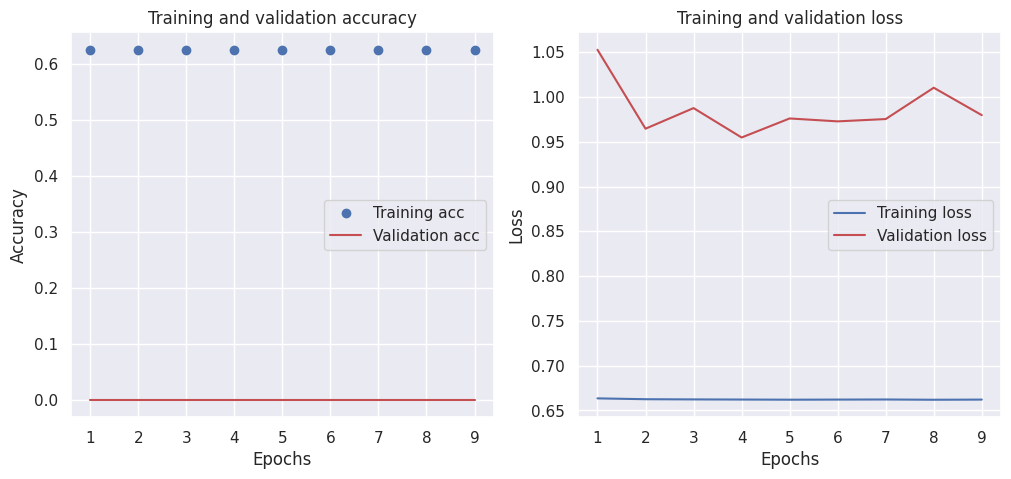

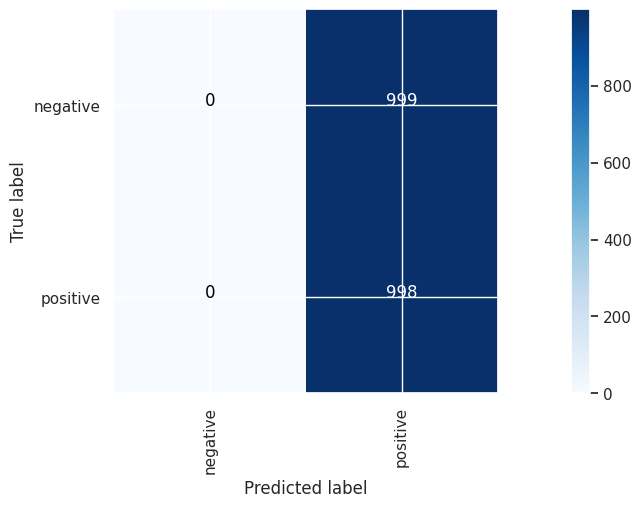

Final Accuracy
0.499749624436655
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_31 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 gru_43 (GRU)                (None, 64)                22272     
                                                                 
 dense_35 (Dense)            (None, 2)                 130       
                                                                 
Total params: 1511052 (5.76 MB)
Trainable params: 1511052 (5.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 24s 94ms/step - loss: 0.4035 - accuracy: 0.8046 - val_loss:

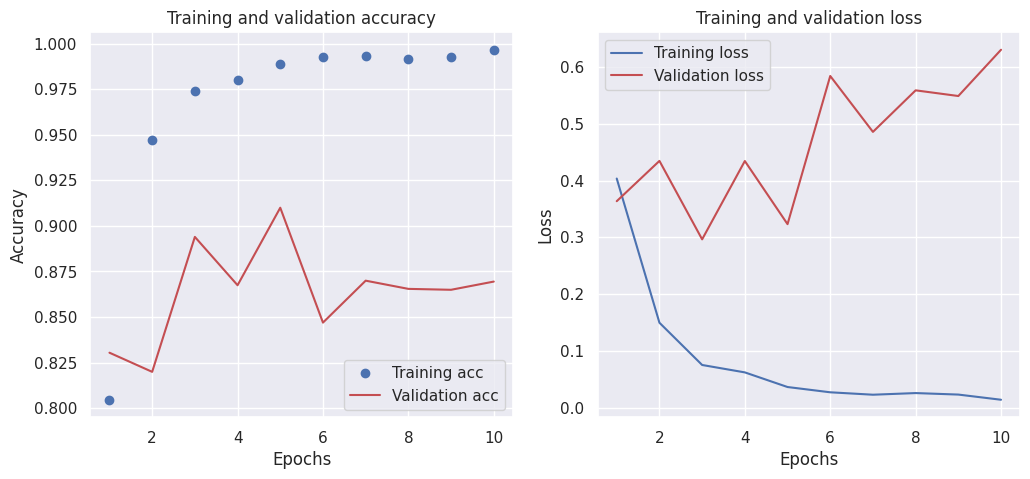

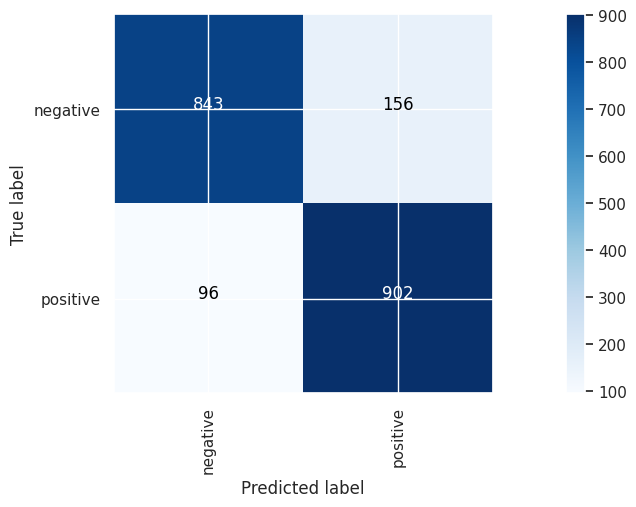

Final Accuracy
0.8738107160741112
Model: "Exp06LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_32 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 gru_44 (GRU)                (None, 64)                22272     
                                                                 
 dense_36 (Dense)            (None, 2)                 130       
                                                                 
Total params: 1511052 (5.76 MB)
Trainable params: 1511052 (5.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 24s 92ms/step - loss: 0.4770 - accuracy: 0.7621 - val_loss

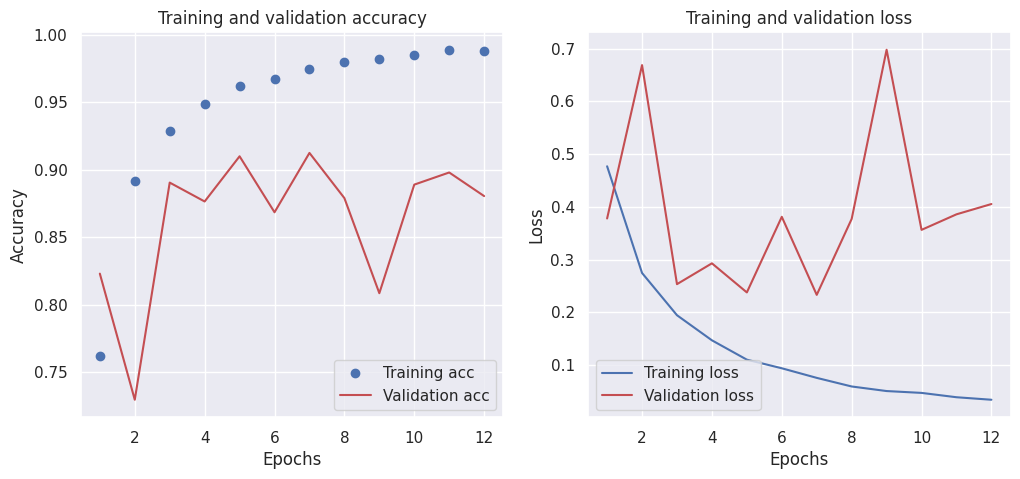

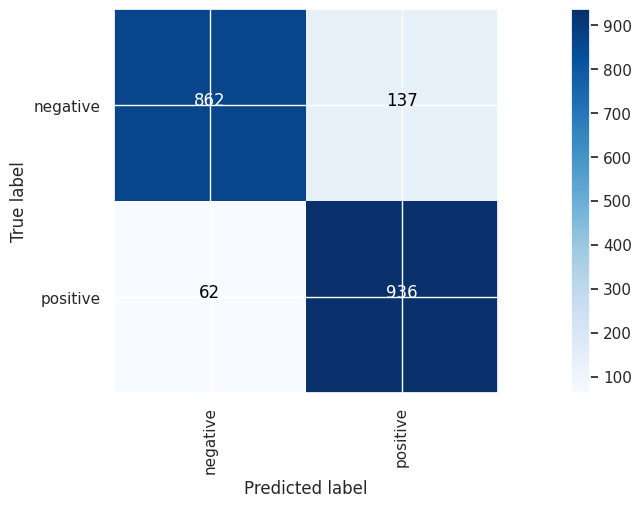

Final Accuracy
0.900350525788683


In [25]:
results = []
name = "GRU"
description =   """
                layers_units=[64],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.15],
                recurrent_dropout=[0.0],
                make_it_bidirectional=False,
                kernel_regularizer=kernel_regularizer=None
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[64]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.15]
recurrent_dropout=[0.0,0.0]
make_it_bidirectional=False
kernel_regularizer=kernel_regularizer=None


# VSM models
for rep in vsm_model:
    build_exp06(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                layers_units=layers_units,
                extra_dense_layer_nn=extra_dense_layer_nn,
                extra_dense_dropout_layer=extra_dense_dropout_layer,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                make_it_bidirectional=make_it_bidirectional,
                kernel_regularizer=kernel_regularizer  
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp06(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer     
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp06(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer    
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_06_14.csv", index=False)

## Conclusiones

In [7]:
join_csv_for_experiment("06", 14)
pd.read_csv("exp_06.csv").sort_values(by=["accuracy"], ascending=False, ignore_index=True)[["classifier", "rep.model", "accuracy","precision","recall"]]

,classifier,rep.model,accuracy,precision,recall
0,"Exp06GRU layers_units=[128],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.15],recurrent_dropout=[0.0],make_it_bidirectional=False,kernel_regularizer=kernel_regularizer=None",Word embedding with GloVe,0.908363,0.908811,0.908363
1,"Exp06GRU layers_units=[64],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.3],recurrent_dropout=[0.0],make_it_bidirectional=False,kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)",Word embedding with GloVe,0.902354,0.902743,0.902354
2,"Exp06GRU layers_units=[8],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.5],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)",Word embedding with GloVe,0.902354,0.903327,0.902354
3,"Exp06GRU layers_units=[64],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.15],recurrent_dropout=[0.0],make_it_bidirectional=False,kernel_regularizer=kernel_regularizer=None",Word embedding with GloVe,0.900351,0.902626,0.900351
4,"Exp06GRU layers_units=[8],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.3],recurrent_dropout=[0.0],make_it_bidirectional=False,kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)",Word embedding with GloVe,0.898348,0.899746,0.898348
5,"Exp06GRU layers_units=[8],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.3],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=kernel_regularizer=None",Word embedding with GloVe,0.895844,0.897096,0.895844
6,"Exp06GRU layers_units=[8],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.3],recurrent_dropout=[0.0],make_it_bidirectional=False,kernel_regularizer=None",Word embedding with GloVe,0.891838,0.897586,0.891838
7,"Exp06GRU layers_units=[8,16,32],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.0,0.2,0.5],recurrent_dropout=[0.0,0.0,0.0],make_it_bidirectional=True,kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)",Word embedding with GloVe,0.884827,0.884833,0.884827
8,"Exp06GRU layers_units=[8],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.0],recurrent_dropout=[0.0],make_it_bidirectional=False,kernel_regularizer=None",Word embedding with GloVe,0.883826,0.886067,0.883826
9,"Exp06GRU layers_units=[128],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.0],recurrent_dropout=[0.0,0.0],make_it_bidirectional=False,kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)",Word embedding with GloVe,0.879820,0.881700,0.879820
